In [99]:
import pandas as pd
import os
import re
import sys
import sklearn
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.lines as mlines
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Road Datasets

In [3]:
# Load Datasets

all_bms_df = pd.read_csv('../data/ALL_BMS.csv')
all_server_df = pd.read_csv('../data/ALL_SERVER.csv')

raw_bms_df = pd.read_csv('../data/Raw_data_from_BMS.csv')
raw_server_df = pd.read_csv('../data/Raw_data_from_server.csv')

server_bms_df = pd.read_csv('../data/data_from_server_bms.csv')
test_df = pd.read_csv('../data/test.csv')
header_df = pd.read_excel('../data/data_headers.xlsx')

In [4]:
dfs = {
    "all_bms": all_bms_df,
    "all_server": all_server_df,
    "raw_bms": raw_bms_df,
    "raw_server": raw_server_df,
    "server_bms": server_bms_df,
    "test": test_df,
    # "header": header_df
}

for name, df in dfs.items():
    print(f"\n{name} ---------------------------")
    print("Shape:", df.shape)
    print("Columns:", df.columns[:15].tolist(), '...'),


all_bms ---------------------------
Shape: (284968, 171)
Columns: ['Unnamed: 0', 'date', 'FCU-01 Watt', 'FCU-1 Cooling Load_kW', 'FCU-01 KWh', 'FCU-01 CHW Supply Temp', 'FCU-01 CHW Return Temp', 'FCU-01 Return Air CO2 Level', 'FCU-01 Return Air Humi', 'FCU-01 Return Temp', 'FCU-01 Supply Air Flow Rate', 'FCU-01 Supply Air Humi', 'FCU-01 Supply Air Temp', 'FCU-01 CHW Flow Rate', 'FCU-02 CHW Flow Rate_x'] ...

all_server ---------------------------
Shape: (284968, 171)
Columns: ['Unnamed: 0', 'date', 'FCU-01 Watt', 'FCU-1 Cooling Load_kW', 'FCU-01 KWh', 'FCU-01 CHW Supply Temp', 'FCU-01 CHW Return Temp', 'FCU-01 Return Air CO2 Level', 'FCU-01 Return Air Humi', 'FCU-01 Return Temp', 'FCU-01 Supply Air Flow Rate', 'FCU-01 Supply Air Humi', 'FCU-01 Supply Air Temp', 'FCU-01 CHW Flow Rate', 'FCU-02 CHW Flow Rate_x'] ...

raw_bms ---------------------------
Shape: (284968, 34)
Columns: ['Unnamed: 0', 'Timestamp', 'FCU-1 Cooling Load_kW', 'FCU-2 Cooling Load_kW', 'FCU-3 Cooling Load_kW', 'FCU

# Primary Preprocessing

In [5]:
# Preprocess dfs

for name, df in dfs.items():
    # 1) Unify Column name as 'Timestamp' (date -> timestamp)
    if "date" in df.columns:   
        df.rename(columns={"date": "Timestamp"}, inplace=True)
        
    # 2) Delete 'Unnamed' column 
    df.drop(columns=[col for col in df.columns if "Unnamed" in col], inplace=True, errors="ignore")

In [6]:
# Check after preprocessing

for name, df in dfs.items():
    print(f"\n{name} ---------------------------")
    print("Shape:", df.shape)
    print("Columns:", df.columns[:15].tolist(), '...'),


all_bms ---------------------------
Shape: (284968, 170)
Columns: ['Timestamp', 'FCU-01 Watt', 'FCU-1 Cooling Load_kW', 'FCU-01 KWh', 'FCU-01 CHW Supply Temp', 'FCU-01 CHW Return Temp', 'FCU-01 Return Air CO2 Level', 'FCU-01 Return Air Humi', 'FCU-01 Return Temp', 'FCU-01 Supply Air Flow Rate', 'FCU-01 Supply Air Humi', 'FCU-01 Supply Air Temp', 'FCU-01 CHW Flow Rate', 'FCU-02 CHW Flow Rate_x', 'FCU-01 Temp Set Point'] ...

all_server ---------------------------
Shape: (284968, 170)
Columns: ['Timestamp', 'FCU-01 Watt', 'FCU-1 Cooling Load_kW', 'FCU-01 KWh', 'FCU-01 CHW Supply Temp', 'FCU-01 CHW Return Temp', 'FCU-01 Return Air CO2 Level', 'FCU-01 Return Air Humi', 'FCU-01 Return Temp', 'FCU-01 Supply Air Flow Rate', 'FCU-01 Supply Air Humi', 'FCU-01 Supply Air Temp', 'FCU-01 CHW Flow Rate', 'FCU-02 CHW Flow Rate_x', 'FCU-01 Temp Set Point'] ...

raw_bms ---------------------------
Shape: (284968, 33)
Columns: ['Timestamp', 'FCU-1 Cooling Load_kW', 'FCU-2 Cooling Load_kW', 'FCU-3 Cool

# Compare dfs

## 1) Compare Rows (Timestamps)

In [7]:
for name, df in dfs.items():
    if "Timestamp" in df.columns:
        if name == "header":   # Pass 'header_df' as they do not have rows
            continue
        
        print(f"\n{name} ---------------------------")
        print("First 10 Timestamps:")
        print(df["Timestamp"].head(10).tolist())
        print("Last 10 Timestamps:")
        print(df["Timestamp"].tail(10).tolist())


all_bms ---------------------------
First 10 Timestamps:
['2024-03-13 08:39:00', '2024-03-13 08:40:00', '2024-03-13 08:41:00', '2024-03-13 08:42:00', '2024-03-13 08:43:00', '2024-03-13 08:44:00', '2024-03-13 08:45:00', '2024-03-13 08:46:00', '2024-03-13 08:47:00', '2024-03-13 08:48:00']
Last 10 Timestamps:
['2024-03-11 17:21:00', '2024-03-11 17:22:00', '2024-03-11 17:23:00', '2024-03-11 17:24:00', '2024-03-13 05:48:00', '2024-02-02 05:03:00', '2024-02-02 05:04:00', '2024-02-02 05:06:00', '2024-02-02 05:07:00', '2024-02-02 05:08:00']

all_server ---------------------------
First 10 Timestamps:
['2024-03-13 08:39:00', '2024-03-13 08:40:00', '2024-03-13 08:41:00', '2024-03-13 08:42:00', '2024-03-13 08:43:00', '2024-03-13 08:44:00', '2024-03-13 08:45:00', '2024-03-13 08:46:00', '2024-03-13 08:47:00', '2024-03-13 08:48:00']
Last 10 Timestamps:
['2024-03-11 17:21:00', '2024-03-11 17:22:00', '2024-03-11 17:23:00', '2024-03-11 17:24:00', '2024-03-13 05:48:00', '2024-02-02 05:03:00', '2024-02-

### 1-1) Visualize Original Timestamp

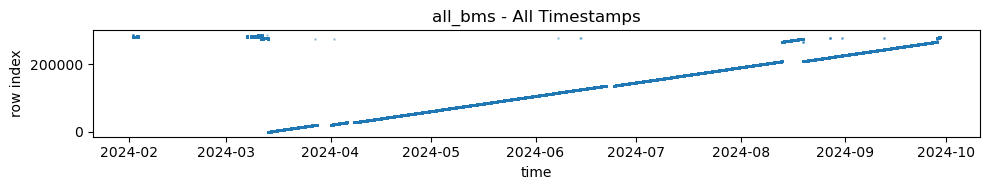

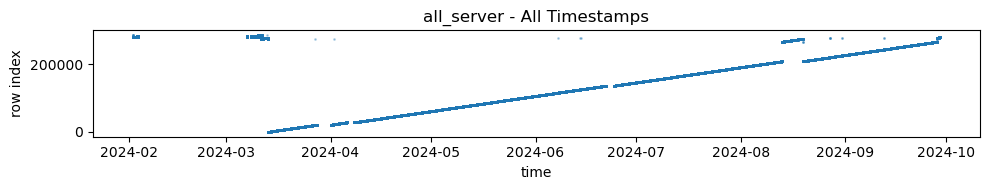

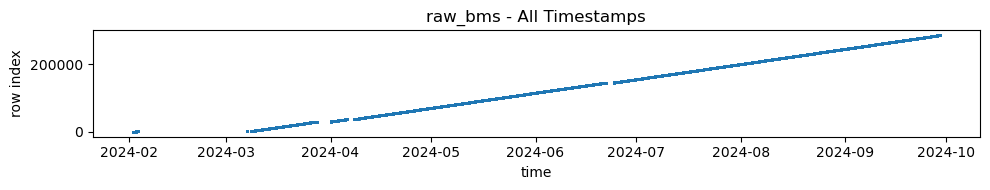

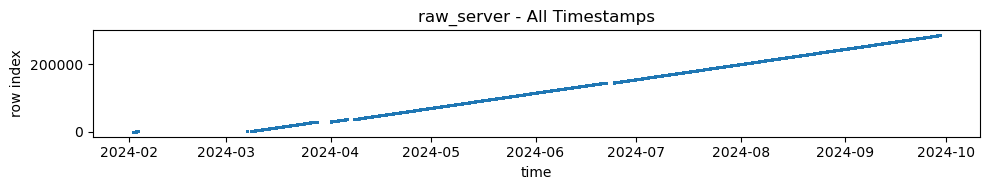

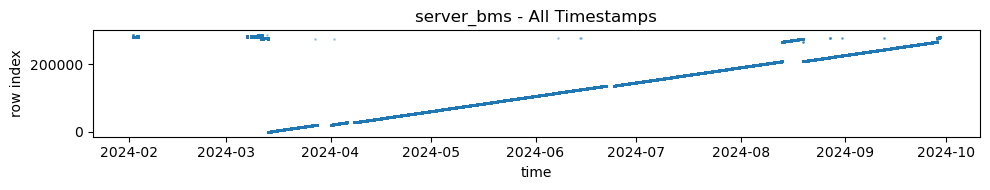

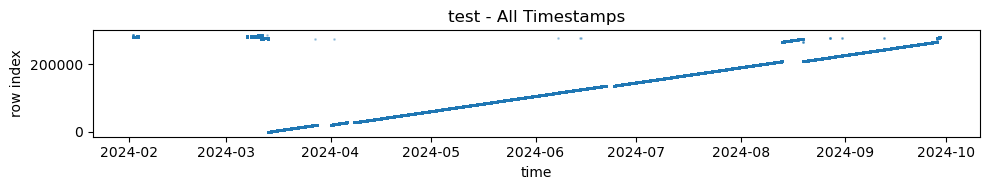

In [8]:
for name, df in dfs.items():
    if "Timestamp" not in df.columns:
        continue
    
    ts = pd.to_datetime(df["Timestamp"], errors="coerce").dropna()
    
    plt.figure(figsize=(10,2))
    plt.plot(ts, range(len(ts)), marker=".", linestyle="", alpha=0.3, markersize=2)
    plt.title(f"{name} - All Timestamps")
    plt.xlabel("time")
    plt.ylabel("row index")
    plt.tight_layout()
    plt.show()


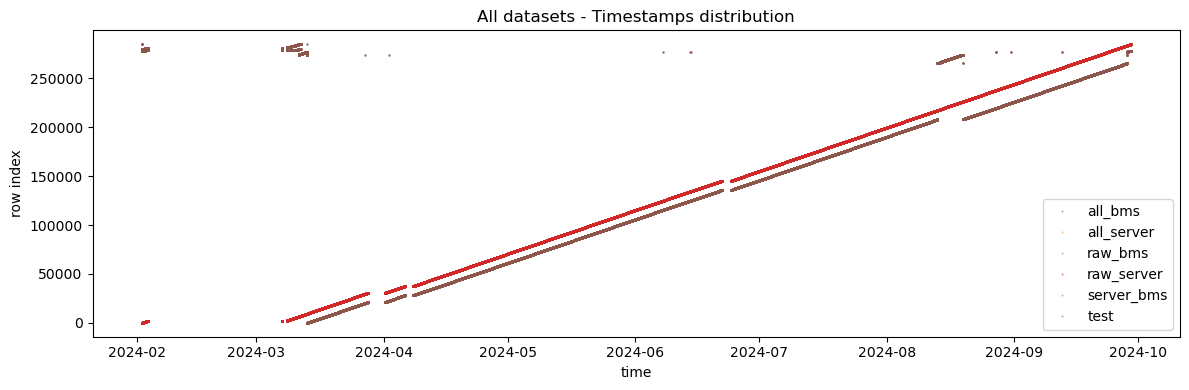

In [9]:
plt.figure(figsize=(12,4))

for name, df in dfs.items():
    if "Timestamp" not in df.columns:
        continue
    
    ts = pd.to_datetime(df["Timestamp"], errors="coerce").dropna()
    
    # 같은 plot 위에 겹쳐 그리기
    plt.plot(ts, range(len(ts)), marker=".", linestyle="", alpha=0.5, markersize=1, label=name)

plt.title("All datasets - Timestamps distribution")
plt.xlabel("time")
plt.ylabel("row index")
plt.legend()
plt.tight_layout()
plt.show()

### 1-2) Rearrange Timestamp

In [10]:
for name, df in dfs.items():
    if "Timestamp" not in df.columns:
        continue
    df.sort_values("Timestamp", inplace=True)
    df.reset_index(drop=True, inplace=True)

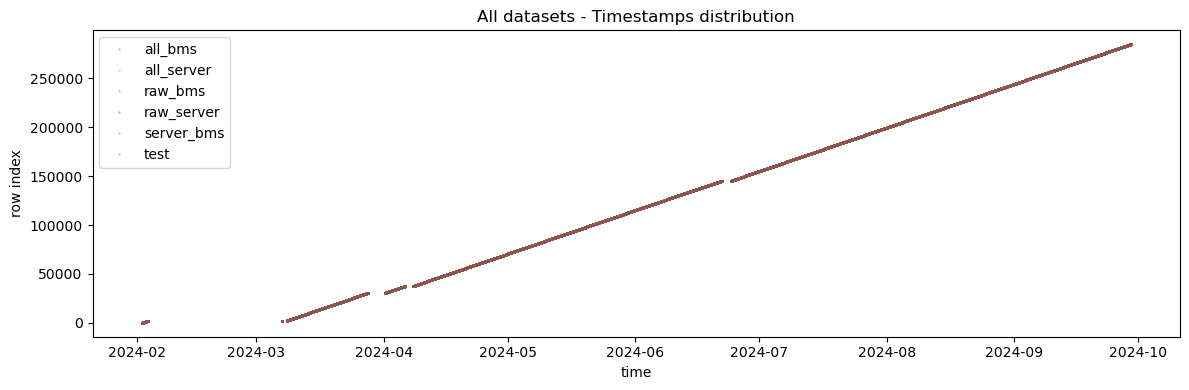

In [11]:
plt.figure(figsize=(12,4))

for name, df in dfs.items():
    if "Timestamp" not in df.columns:
        continue
    
    ts = pd.to_datetime(df["Timestamp"], errors="coerce").dropna()
    
    # 같은 plot 위에 겹쳐 그리기
    plt.plot(ts, range(len(ts)), marker=".", linestyle="", alpha=0.5, markersize=1, label=name)

plt.title("All datasets - Timestamps distribution")
plt.xlabel("time")
plt.ylabel("row index")
plt.legend()
plt.tight_layout()
plt.show()

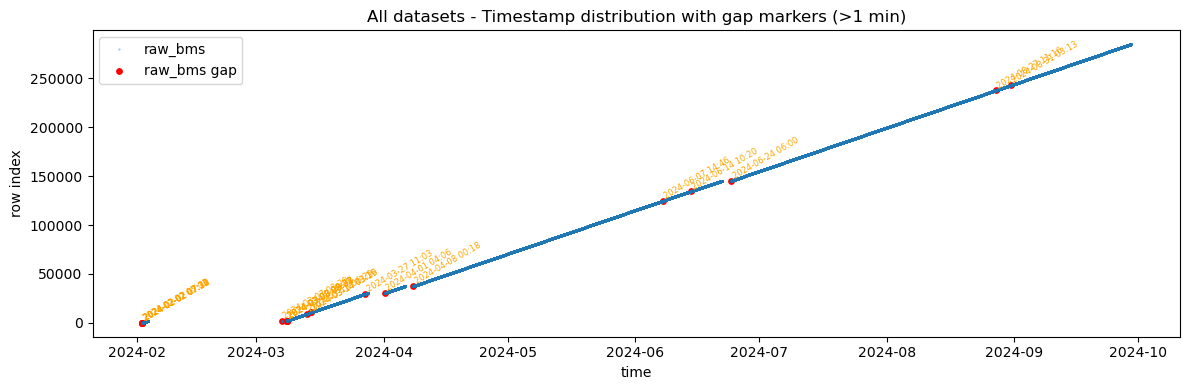

In [44]:
plt.figure(figsize=(12,4))

name = 'raw_bms'
df = dfs[name]

# Convert and sort timestamps
ts = pd.to_datetime(df["Timestamp"], errors="coerce").dropna().sort_values()

# Plot all timestamps
plt.plot(ts, range(len(ts)), marker=".", linestyle="", alpha=0.5, markersize=1, label=name)

# Find discontinuities (> 1 min gap)
diffs = ts.diff()
gaps = diffs[diffs > pd.Timedelta(minutes=1)]

# Mark those discontinuities with orange dots
plt.scatter(ts.loc[gaps.index], gaps.index, color="red", s=15, label=f"{name} gap" if name=="raw_bms" else None)

# Optionally annotate first few gaps
for idx in gaps.index[:]:  # annotate only first 3 to avoid clutter
    plt.text(ts.loc[idx], idx, ts.loc[idx].strftime('%Y-%m-%d %H:%M'),
                color="orange", fontsize=6, rotation=30, ha="left", va="bottom")

plt.title("All datasets - Timestamp distribution with gap markers (>1 min)")
plt.xlabel("time")
plt.ylabel("row index")
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
def find_timestamp_gaps(df, freq="1min"):
    # 1) Ensure Timestamp is datetime
    ts = pd.to_datetime(df["Timestamp"], errors="coerce").dropna().sort_values()

    # 2) Calculate difference between consecutive rows
    diffs = ts.diff()

    # 3) Find where gap is larger than expected frequency
    expected = pd.to_timedelta(freq)
    gaps = diffs[diffs > expected]

    # 4) Report results
    if gaps.empty:
        print("✅ No gaps found in timestamps.")
    else:
        print("⚠️ Gaps detected:")
        for idx, gap in gaps.items():
            print(f" - Gap of {gap} after {ts.loc[idx - 1]} → resumes at {ts.loc[idx]}")


In [37]:
find_timestamp_gaps(raw_bms_df, freq="1min")

⚠️ Gaps detected:
 - Gap of 0 days 00:03:00 after 2024-02-02 05:00:00 → resumes at 2024-02-02 05:03:00
 - Gap of 0 days 00:07:00 after 2024-02-02 07:12:00 → resumes at 2024-02-02 07:19:00
 - Gap of 0 days 00:04:00 after 2024-02-02 07:20:00 → resumes at 2024-02-02 07:24:00
 - Gap of 0 days 00:02:00 after 2024-02-02 07:28:00 → resumes at 2024-02-02 07:30:00
 - Gap of 0 days 00:02:00 after 2024-02-02 07:30:00 → resumes at 2024-02-02 07:32:00
 - Gap of 32 days 11:19:00 after 2024-02-03 16:01:00 → resumes at 2024-03-07 03:20:00
 - Gap of 1 days 02:28:00 after 2024-03-07 05:40:00 → resumes at 2024-03-08 08:08:00
 - Gap of 0 days 00:03:00 after 2024-03-08 08:29:00 → resumes at 2024-03-08 08:32:00
 - Gap of 0 days 00:02:00 after 2024-03-08 08:32:00 → resumes at 2024-03-08 08:34:00
 - Gap of 0 days 00:02:00 after 2024-03-08 09:20:00 → resumes at 2024-03-08 09:22:00
 - Gap of 0 days 00:02:00 after 2024-03-08 09:31:00 → resumes at 2024-03-08 09:33:00
 - Gap of 0 days 00:17:00 after 2024-03-13 06:

## 2) Compare Columns

In [12]:
base_cols = set(dfs["all_bms"].columns)

for name, df in dfs.items():
    diff1 = set(df.columns) - base_cols  # df에는 있고 base에는 없는 것
    diff2 = base_cols - set(df.columns)  # base에는 있고 df에는 없는 것
    
    print(f"\n{name} ---------------------------")
    if not diff1 and not diff2:
        print("✅ Columns identical to raw_bms")
    else:
        if diff1:
            print("Columns only in", name, ":", diff1)
            print("Total:", len(diff1))
        if diff2:
            print("Columns missing in", name, ":", diff2)
            print("Total:", len(diff2))
            
#### RESULT (columns name) ####
# all_bms = all_server = server_bms = test (170 columns)
# raw_bms = raw_server (33 columns)



all_bms ---------------------------
✅ Columns identical to raw_bms

all_server ---------------------------
✅ Columns identical to raw_bms

raw_bms ---------------------------
Columns missing in raw_bms : {'PFCU-01 Supply Air Humi', 'FCU-02 Supply Air Humi_y', 'FCU-03 Supply Air Humi', 'FCU-04 Supply Air Humi', 'FCU-04 Watt', 'Zone 2G2 Fan-1 Control', 'FCU-01 Temp Set Point', 'FCU-01 Supply Air Flow Rate', 'Zone-02 KWh', 'Z2 Windows Open Close Status COV', 'FCU-03 CHW Flow Rate', 'PFCU-02 VAV Z3-1 Air Flow Rate', 'FCU-05 Supply Air Flow Rate', 'FCU-05 Supply Air Humi', 'PFCU-01 Watt', 'Zone 1 Fan-3 Control', 'Zone 1 Fan-5 Control', 'Zone 2G2 Fan-2 Control', 'PFCU-01 VAV Z1-1 Air Flow Rate', 'Z6 Windows Open Close Status COV', 'Zone 2G1 Fan-6 Control', 'Zone 3 Fan-2 Control', 'Zone 1 Fan-6 Control', 'FCU-01 Watt', 'Zone 2G2 Fan-4 Control', 'PFCU-02 Static Pressure', 'Zone 5 Fan-2 Control', 'PFCU-01 VAV Z1-2 Air Flow Rate', 'Zone 2G1 Fan-1 Control', 'FCU-05 Return Air Humi', 'PFCU-02 Wat

## 3) Compare Values

In [13]:
print("Completely equal?")
print("raw_bms vs raw_server", raw_bms_df.equals(raw_server_df))
print("all_bms vs all_server", all_bms_df.equals(all_server_df))
print("all_bms vs server_bms", all_bms_df.equals(server_bms_df))
print("all_server vs server_bms", all_server_df.equals(server_bms_df))
print("all_bms vs test", all_bms_df.equals(test_df))
print("all_server vs test", all_server_df.equals(test_df))

Completely equal?
raw_bms vs raw_server False
all_bms vs all_server True
all_bms vs server_bms False
all_server vs server_bms False
all_bms vs test True
all_server vs test True


In [26]:
common_cols = raw_bms_df.columns.intersection(all_bms_df.columns)

# raw_bms의 공통 컬럼과 all_bms의 같은 컬럼 비교
bms_is_equal = raw_bms_df[common_cols].equals(all_bms_df[common_cols])
print("raw_bms ⊆ all_bms (값 포함)?", bms_is_equal)

# raw_server의 공통 컬럼과 all_server의 같은 컬럼 비교
server_is_equal = raw_server_df[common_cols].equals(all_server_df[common_cols])
print("raw_server ⊆ all_server (값 포함)?", server_is_equal)

# raw_server의 공통 컬럼과 server_bms의 같은 컬럼 비교
server_bms_is_equal = raw_server_df[common_cols].equals(server_bms_df[common_cols])
print("raw_server ⊆ server_bms (값 포함)?", server_bms_is_equal)

raw_bms ⊆ all_bms (값 포함)? True
raw_server ⊆ all_server (값 포함)? False
raw_server ⊆ server_bms (값 포함)? True


#### raw_bms vs raw_server

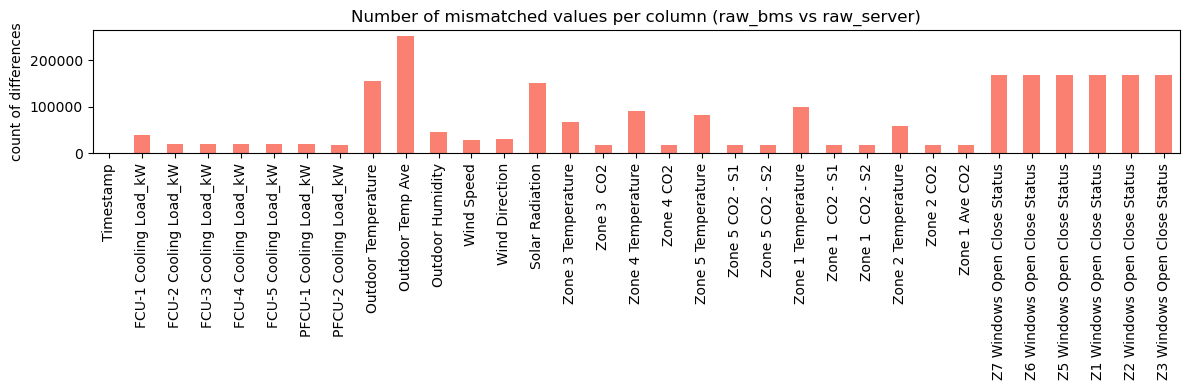

In [13]:
import matplotlib.pyplot as plt

diff_counts = (raw_bms_df != raw_server_df).sum()

plt.figure(figsize=(12,4))
diff_counts.plot(kind="bar", color="salmon")
plt.title("Number of mismatched values per column (raw_bms vs raw_server)")
plt.ylabel("count of differences")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


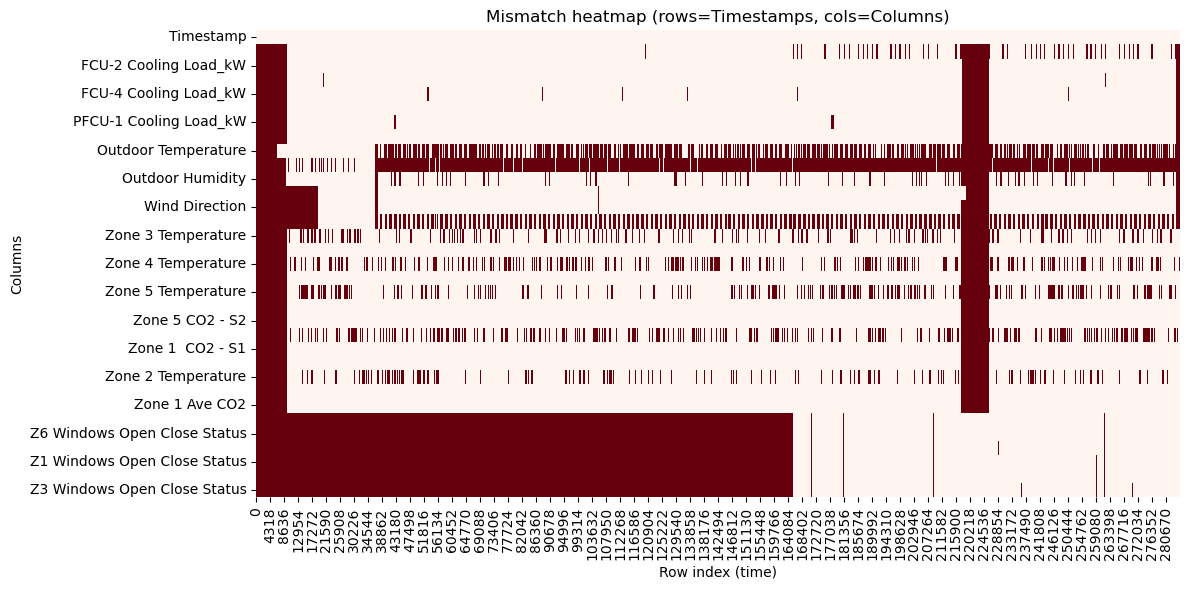

In [ ]:
diff_mask = (raw_bms_df != raw_server_df)

plt.figure(figsize=(12,6))
sns.heatmap(diff_mask.T, cmap="Reds", cbar=False)
plt.title("Mismatch heatmap (rows=Timestamps, cols=Columns)")
plt.xlabel("Row index (time)")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()


all_bms vs server_bms

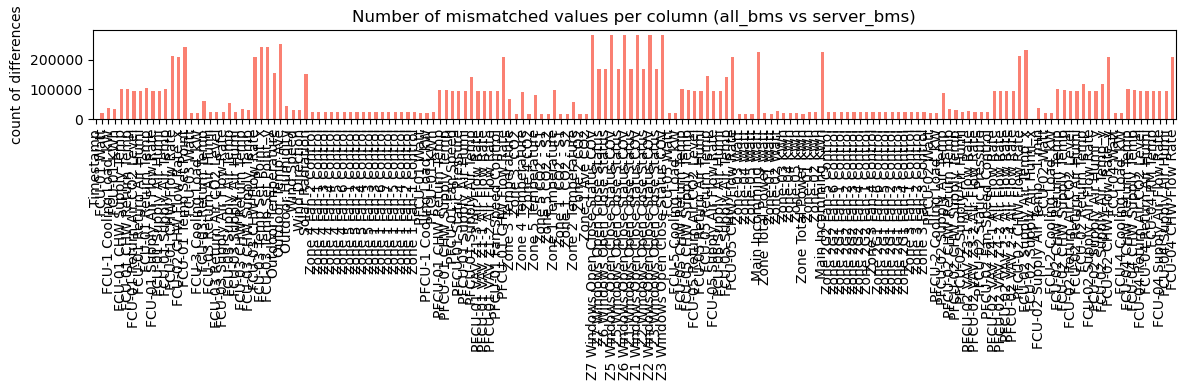

In [23]:
diff_counts = (all_bms_df != server_bms_df).sum()

plt.figure(figsize=(12,4))
diff_counts.plot(kind="bar", color="salmon")
plt.title("Number of mismatched values per column (all_bms vs server_bms)")
plt.ylabel("count of differences")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

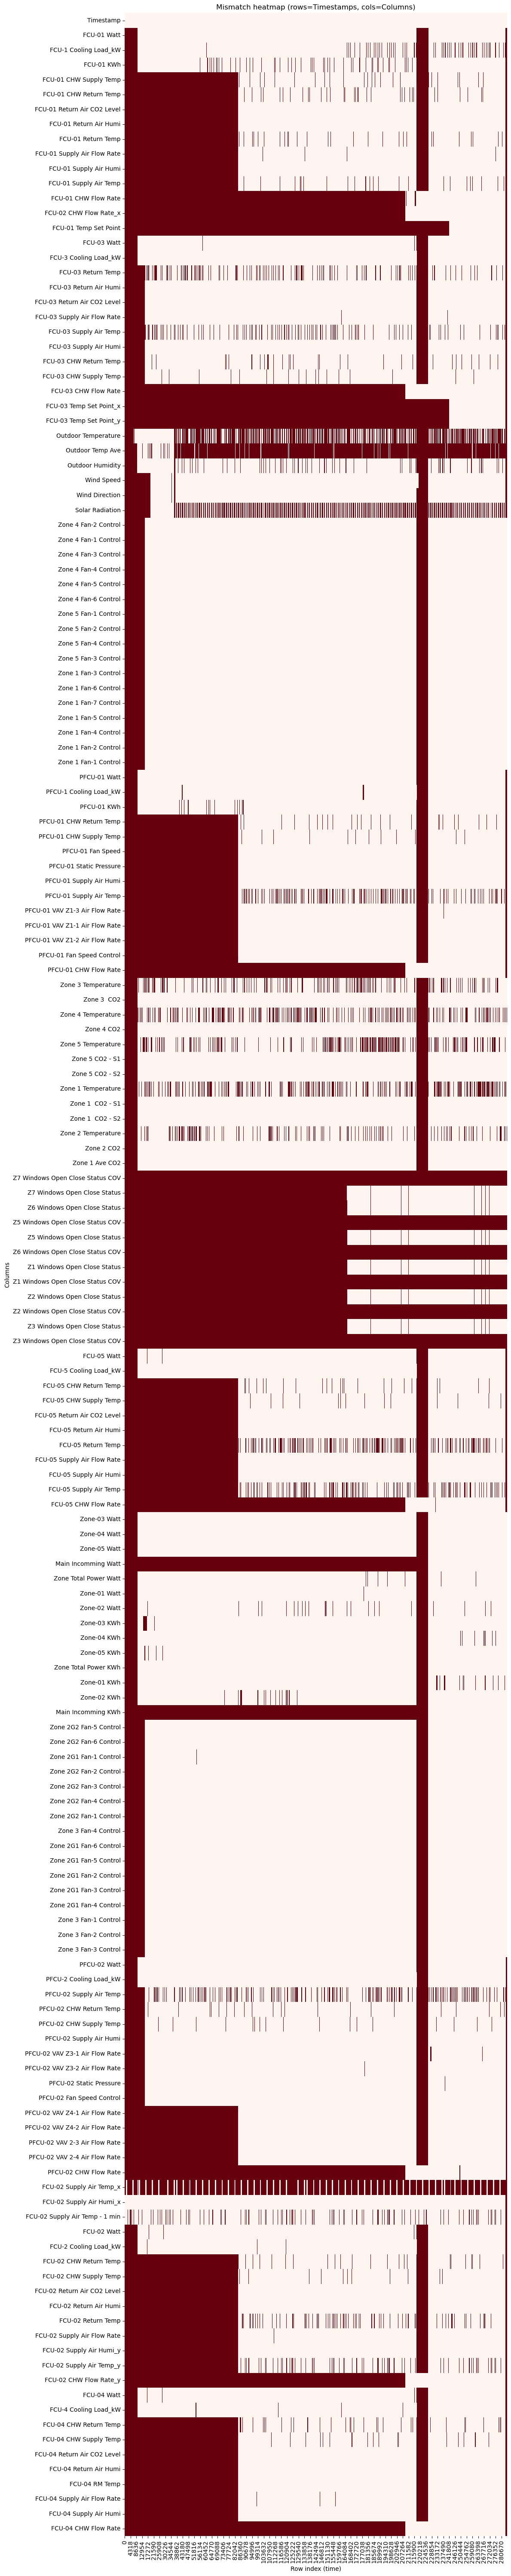

In [24]:
diff_mask = (all_bms_df != server_bms_df)

plt.figure(figsize=(12,60))
sns.heatmap(diff_mask.T, cmap="Reds", cbar=False)
plt.title("Mismatch heatmap (rows=Timestamps, cols=Columns)")
plt.xlabel("Row index (time)")
plt.ylabel("Columns")
plt.tight_layout()
plt.show()

## 4) Compare Null

In [ ]:
def compare_null_positions(df1, df2, name1="df1", name2="df2"):
    # only use common columns (to align shapes)
    common_cols = df1.columns.intersection(df2.columns)
    d1 = df1[common_cols].isna()
    d2 = df2[common_cols].isna()

    # column-wise null equality
    same_mask = (d1 == d2)

    # visualization data: 0=both same, 1=different
    diff_mask = (~same_mask).astype(int)

    # plt.figure(figsize=(12, 6))
    # plt.imshow(diff_mask.T, aspect='auto', cmap="coolwarm", interpolation="nearest")
    # plt.colorbar(label="Null mismatch (0=Same, 1=Different)")
    # plt.title(f"Null position comparison: {name1} vs {name2}")
    # plt.xlabel("Row index")
    # plt.ylabel("Columns")
    # plt.yticks(range(len(common_cols)), common_cols)
    # plt.show()

    # simple report
    diff_count = diff_mask.values.sum()
    print(f"Total {diff_count} positions {name1}and {name2}have different null values.")

In [24]:
compare_null_positions(raw_bms_df, raw_server_df, "raw_bms", "raw_server")
compare_null_positions(all_server_df, raw_server_df, "all_server", "raw_server")
compare_null_positions(all_bms_df, server_bms_df, "all_bms", "server_bms")

총 0개 위치에서 raw_bms과 raw_server의 null 여부가 다릅니다.
총 0개 위치에서 all_server과 raw_server의 null 여부가 다릅니다.
총 0개 위치에서 all_bms과 server_bms의 null 여부가 다릅니다.


/var/folders/lb/jj_27gpd4f1_bzrx7k_h79880000gn/T/ipykernel_34493/463574209.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/lb/jj_27gpd4f1_bzrx7k_h79880000gn/T/ipykernel_34493/463574209.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/lb/jj_27gpd4f1_bzrx7k_h79880000gn/T/ipykernel_34493/463574209.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


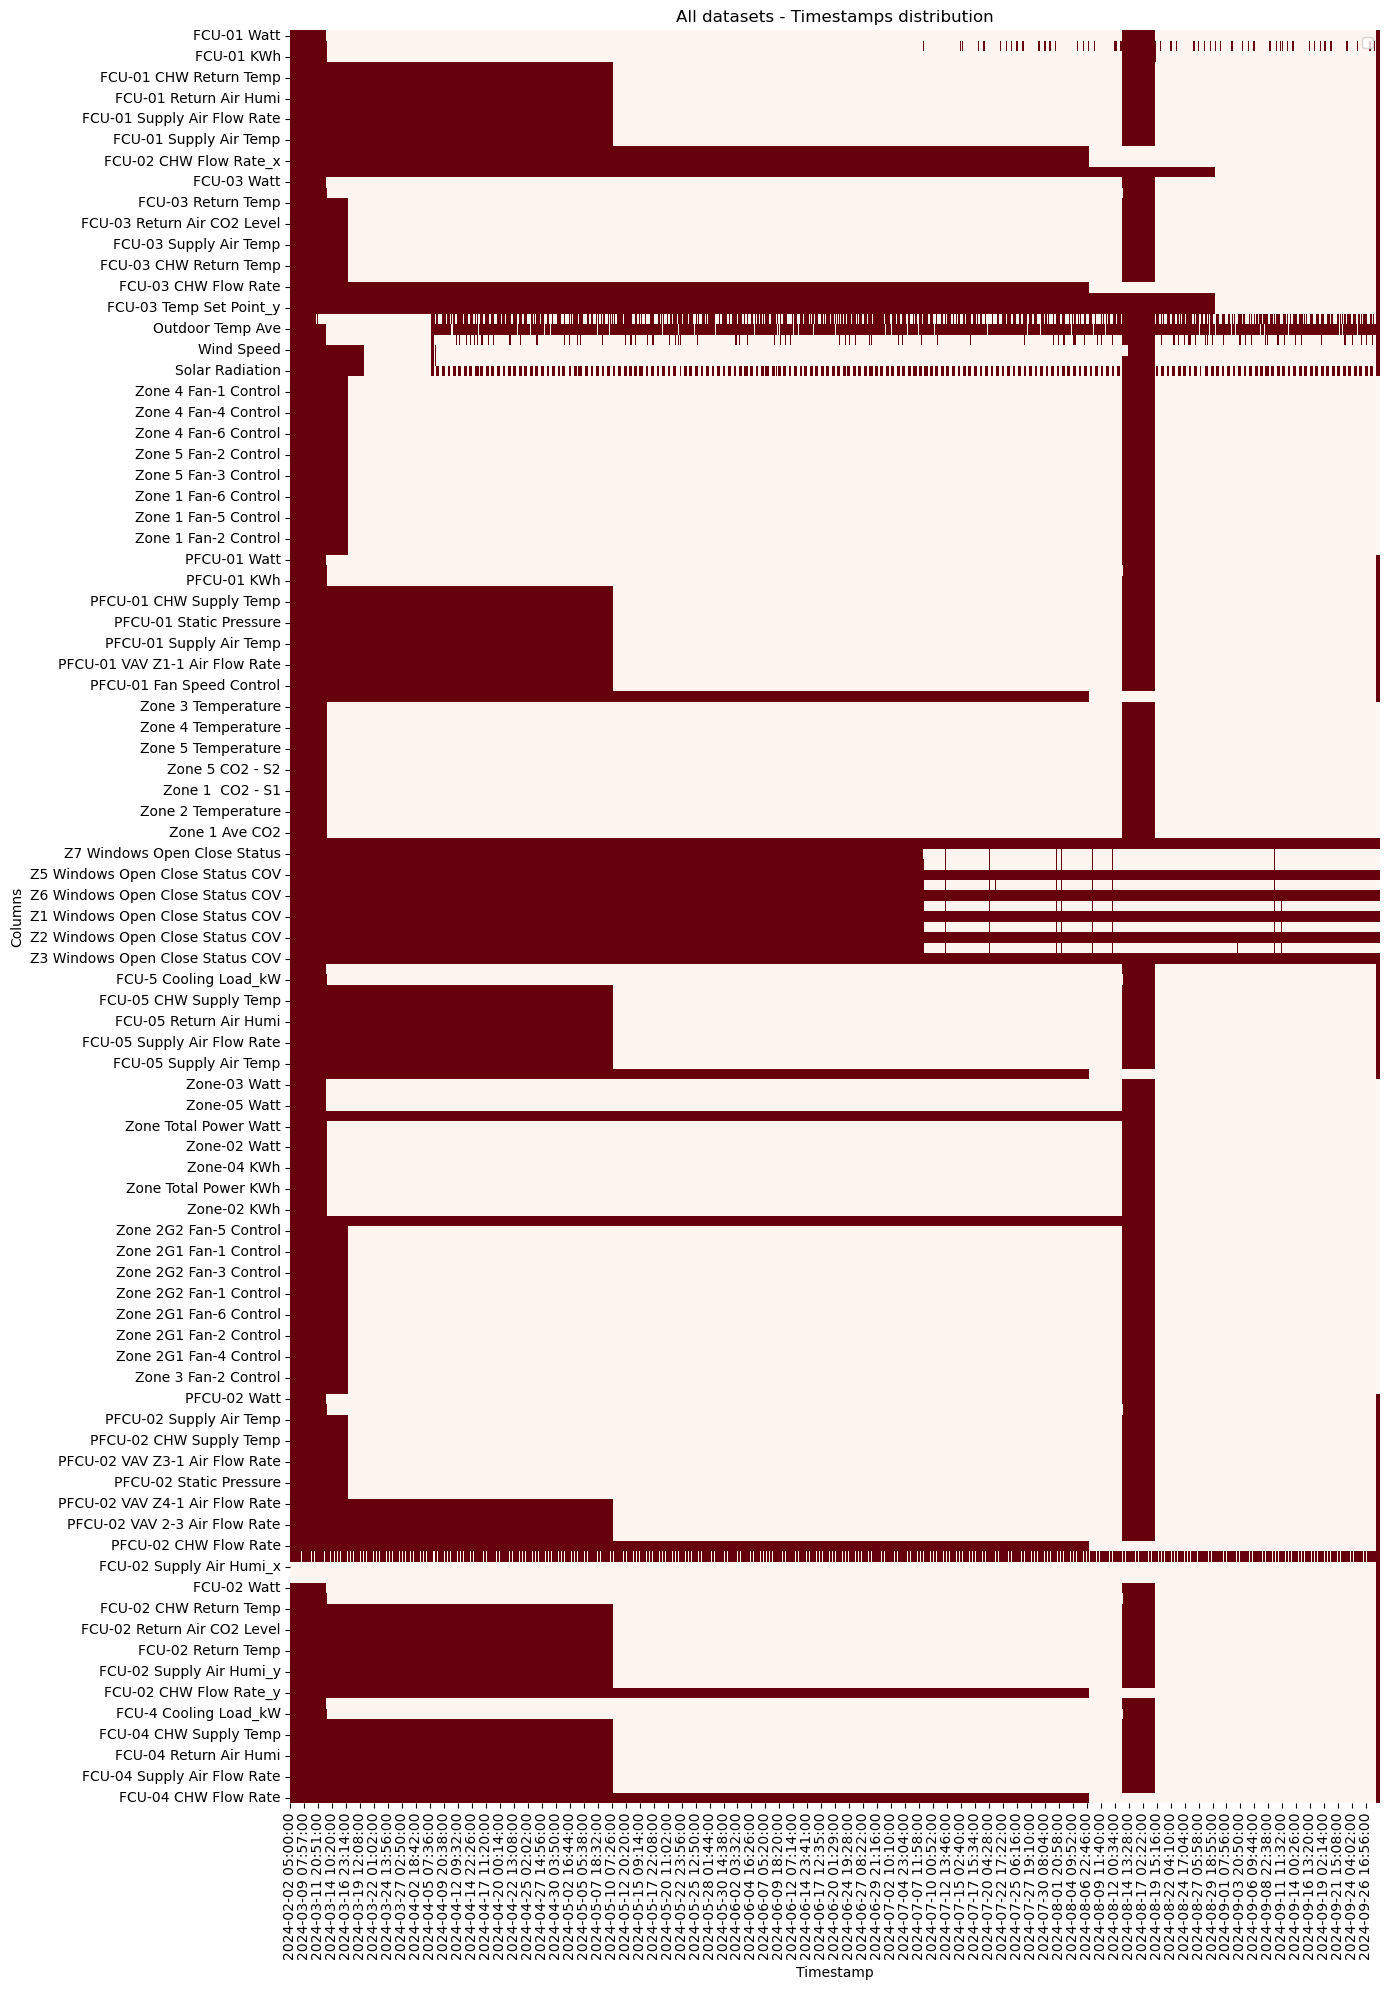

In [25]:
null_mask = dfs['all_bms'].set_index("Timestamp").isna()
plt.figure(figsize=(14,20))
sns.heatmap(
    null_mask.T,          # 행=컬럼, 열=Timestamp
    cmap="Reds",          # 빨강=결측
    cbar=False,
    label='all_bms'
)
plt.title("All datasets - Timestamps distribution")
plt.xlabel("Timestamp")
plt.ylabel("Columns")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/lb/jj_27gpd4f1_bzrx7k_h79880000gn/T/ipykernel_34493/1241383962.py:12: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/lb/jj_27gpd4f1_bzrx7k_h79880000gn/T/ipykernel_34493/1241383962.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/lb/jj_27gpd4f1_bzrx7k_h79880000gn/T/ipykernel_34493/1241383962.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


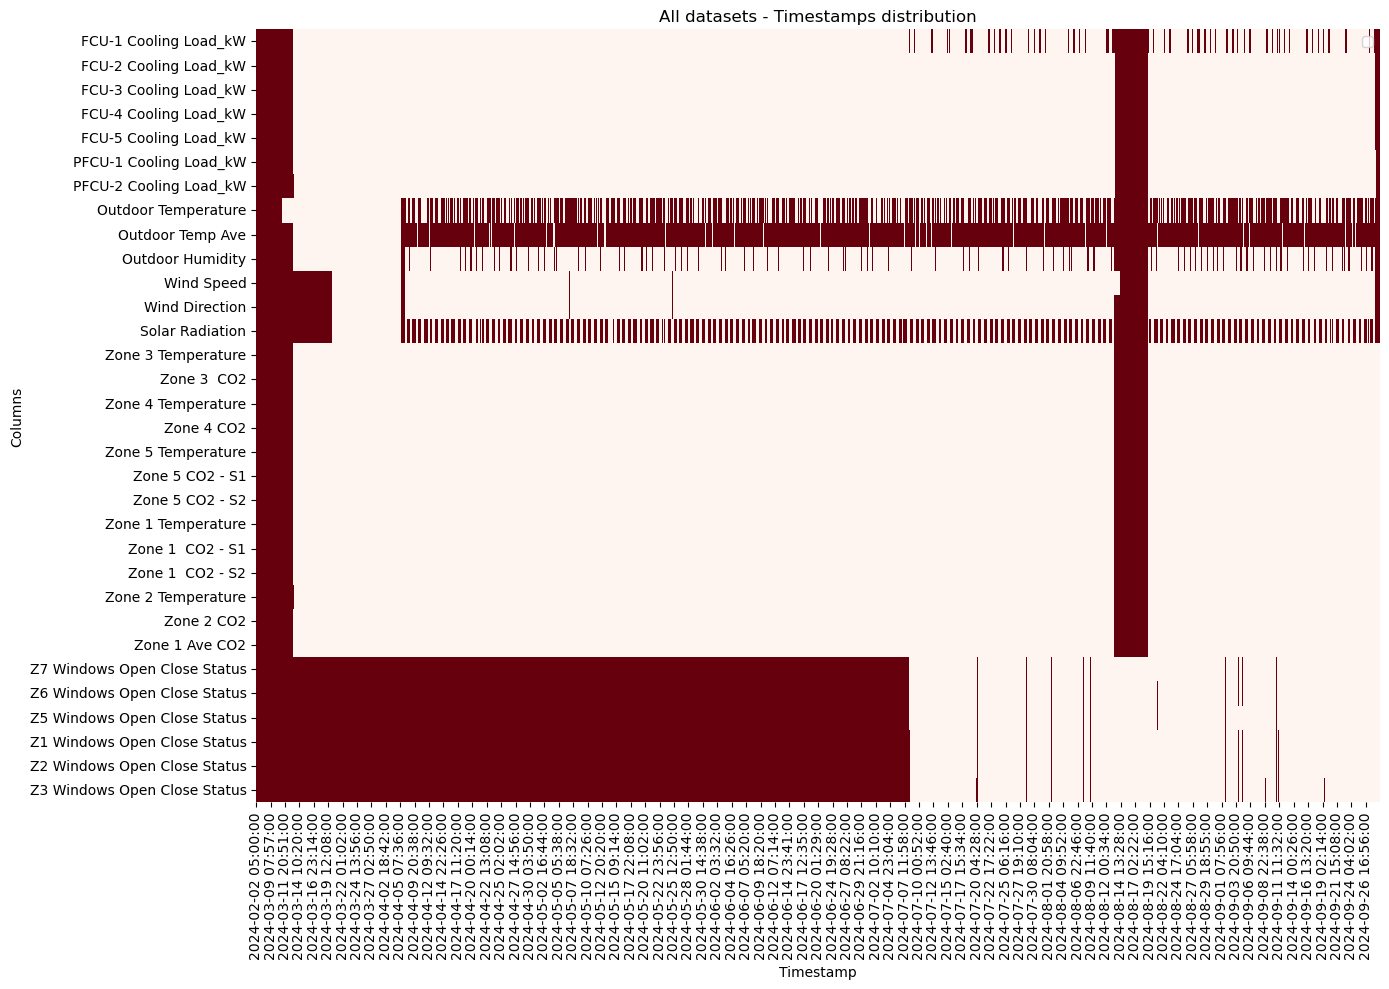

In [33]:
null_mask = dfs['raw_bms'].set_index("Timestamp").isna()
plt.figure(figsize=(14,10))
sns.heatmap(
    null_mask.T,          # 행=컬럼, 열=Timestamp
    cmap="Reds",          # 빨강=결측
    cbar=False,
    label='raw_bms'
)
plt.title("All datasets - Timestamps distribution")
plt.xlabel("Timestamp")
plt.ylabel("Columns")
plt.legend()
plt.tight_layout()
plt.show()

Preprocess Columns

In [ ]:
def collect_columns(df, prefix):
    """
    Collect all columns that start with 'FCU-' into a single list.
    Handles both 'FCU-1' and 'FCU-01' consistently.
    """
    cols = []
    for col in df.columns:
        if col.startswith(prefix):
            cols.append(col)
    return sorted(cols)

In [96]:
outdoor_cols = [
    'Outdoor Temperature', 
    'Outdoor Temp Ave', 
    'Outdoor Humidity', 
    'Wind Speed', 
    'Wind Direction', 
    'Solar Radiation'
]
main_cols = [
    'Main Incomming Watt', 
    'Main Incomming KWh', 
]
window_cols = [
    'Z1 Windows Open Close Status', 'Z1 Windows Open Close Status COV', 
    'Z2 Windows Open Close Status', 'Z2 Windows Open Close Status COV', 
    'Z3 Windows Open Close Status', 'Z3 Windows Open Close Status COV', 
    'Z5 Windows Open Close Status', 'Z5 Windows Open Close Status COV', 
    'Z6 Windows Open Close Status', 'Z6 Windows Open Close Status COV', 
    'Z7 Windows Open Close Status', 'Z7 Windows Open Close Status COV'
]
fcu_cols = collect_columns(server_bms_df, prefix="FCU-")
zone_cols = collect_columns(server_bms_df, prefix="Zone")
pfcu_cols = collect_columns(server_bms_df, prefix="PFCU-")


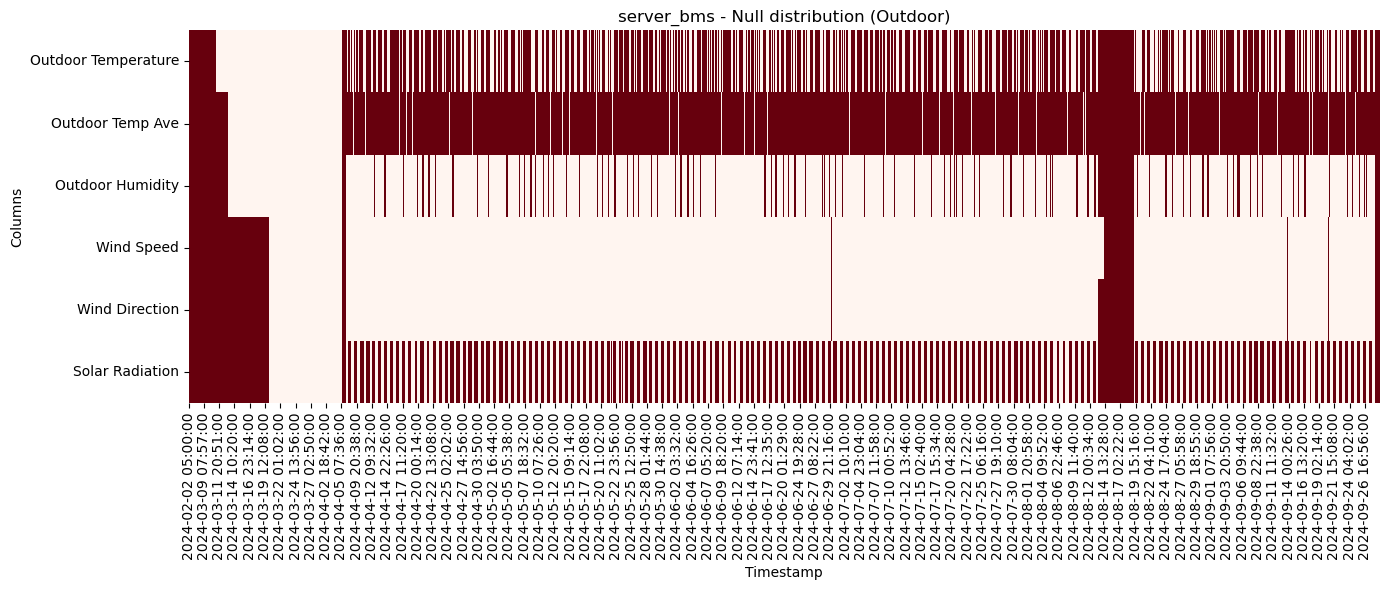

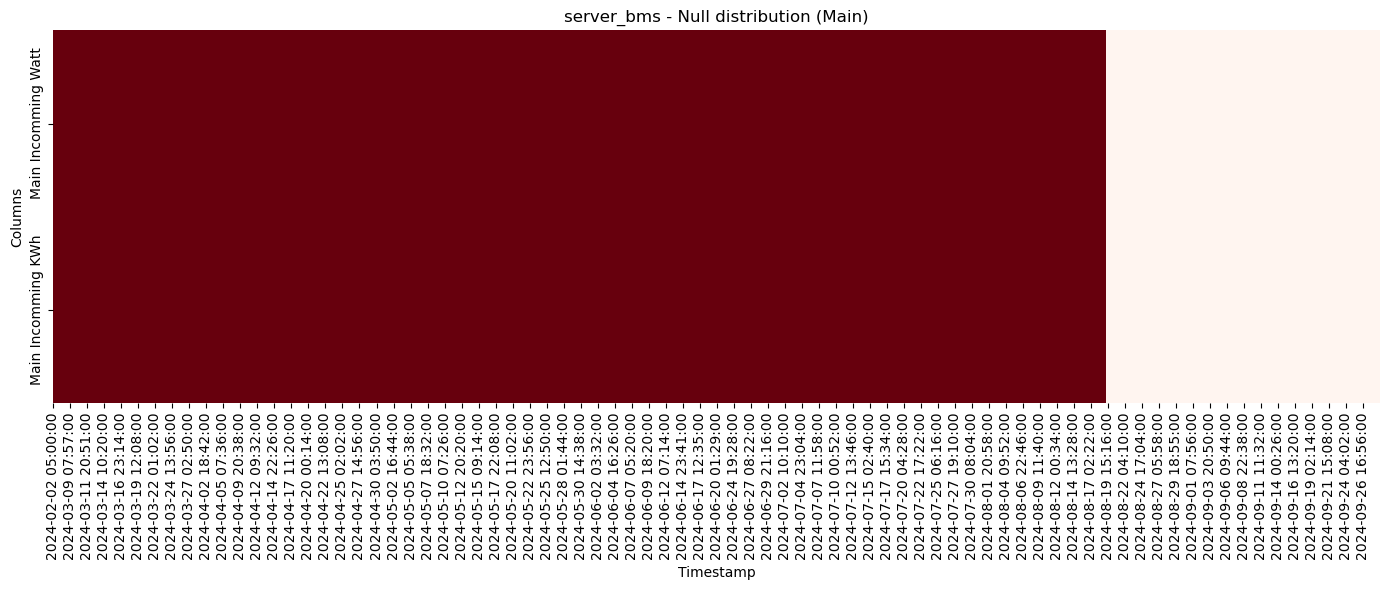

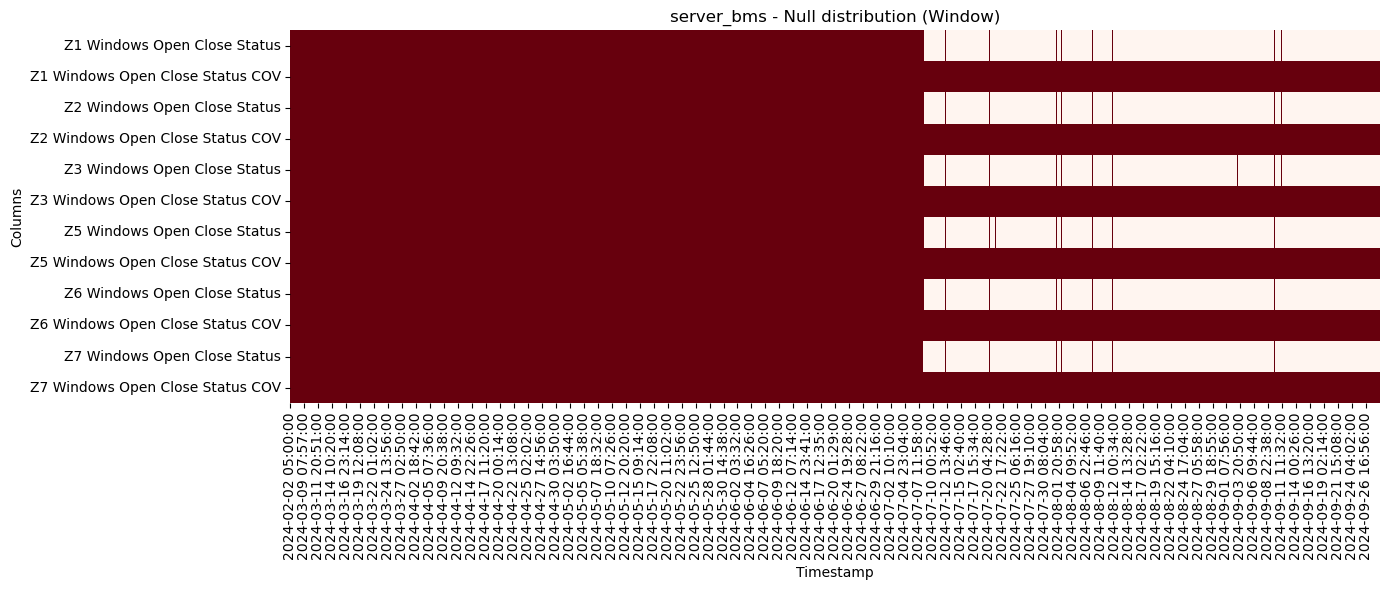

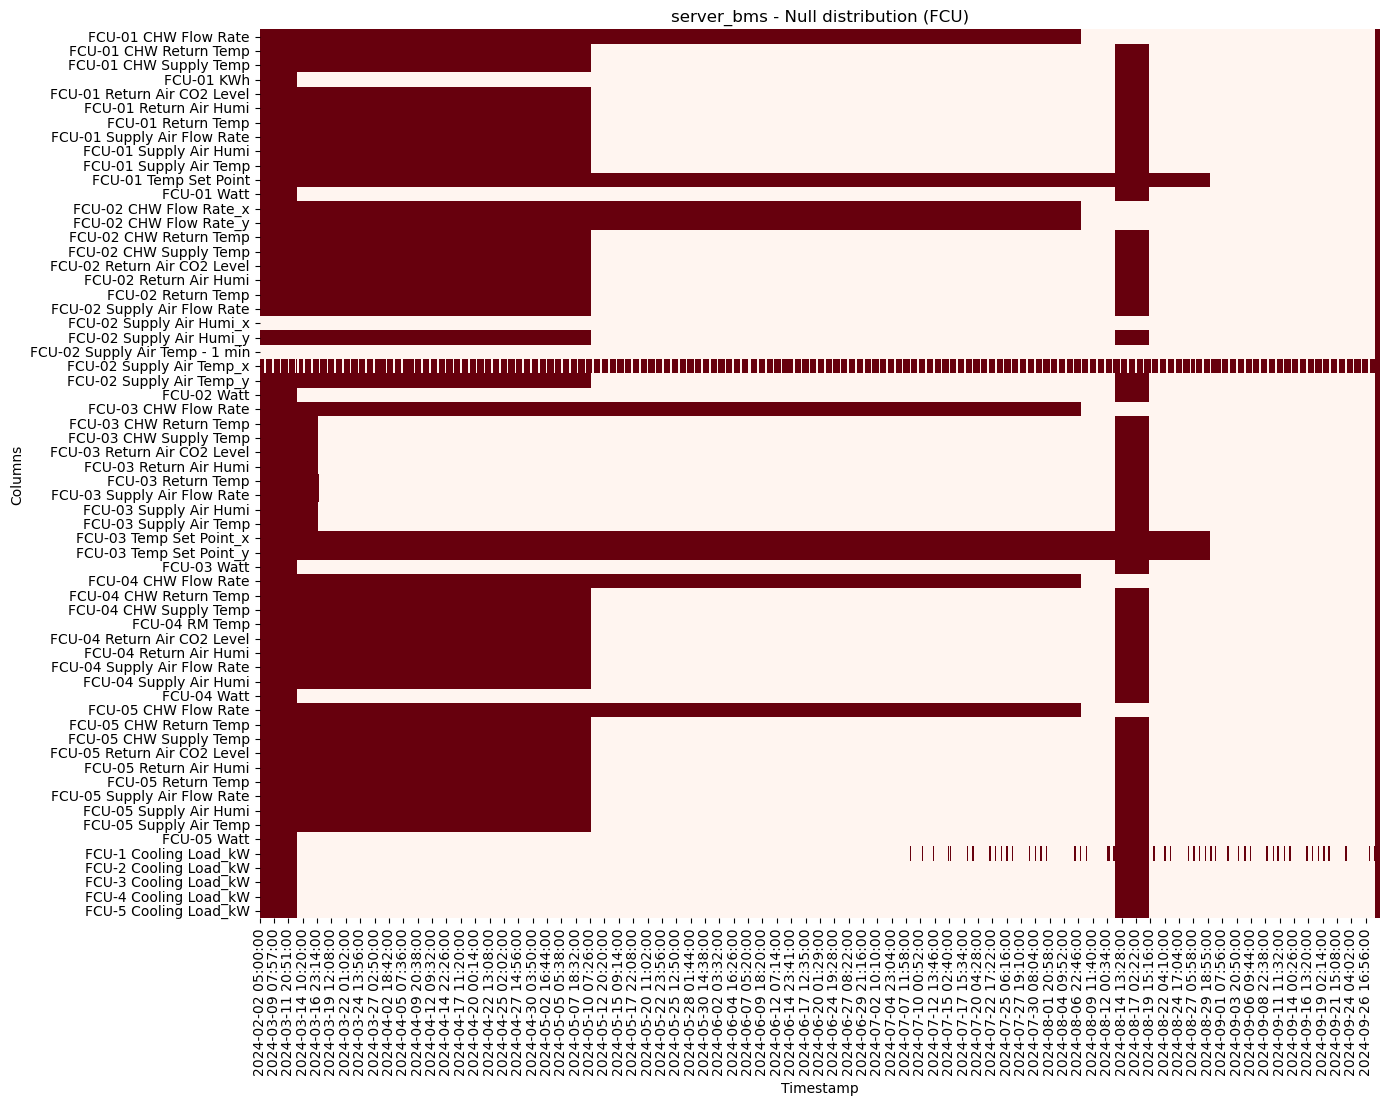

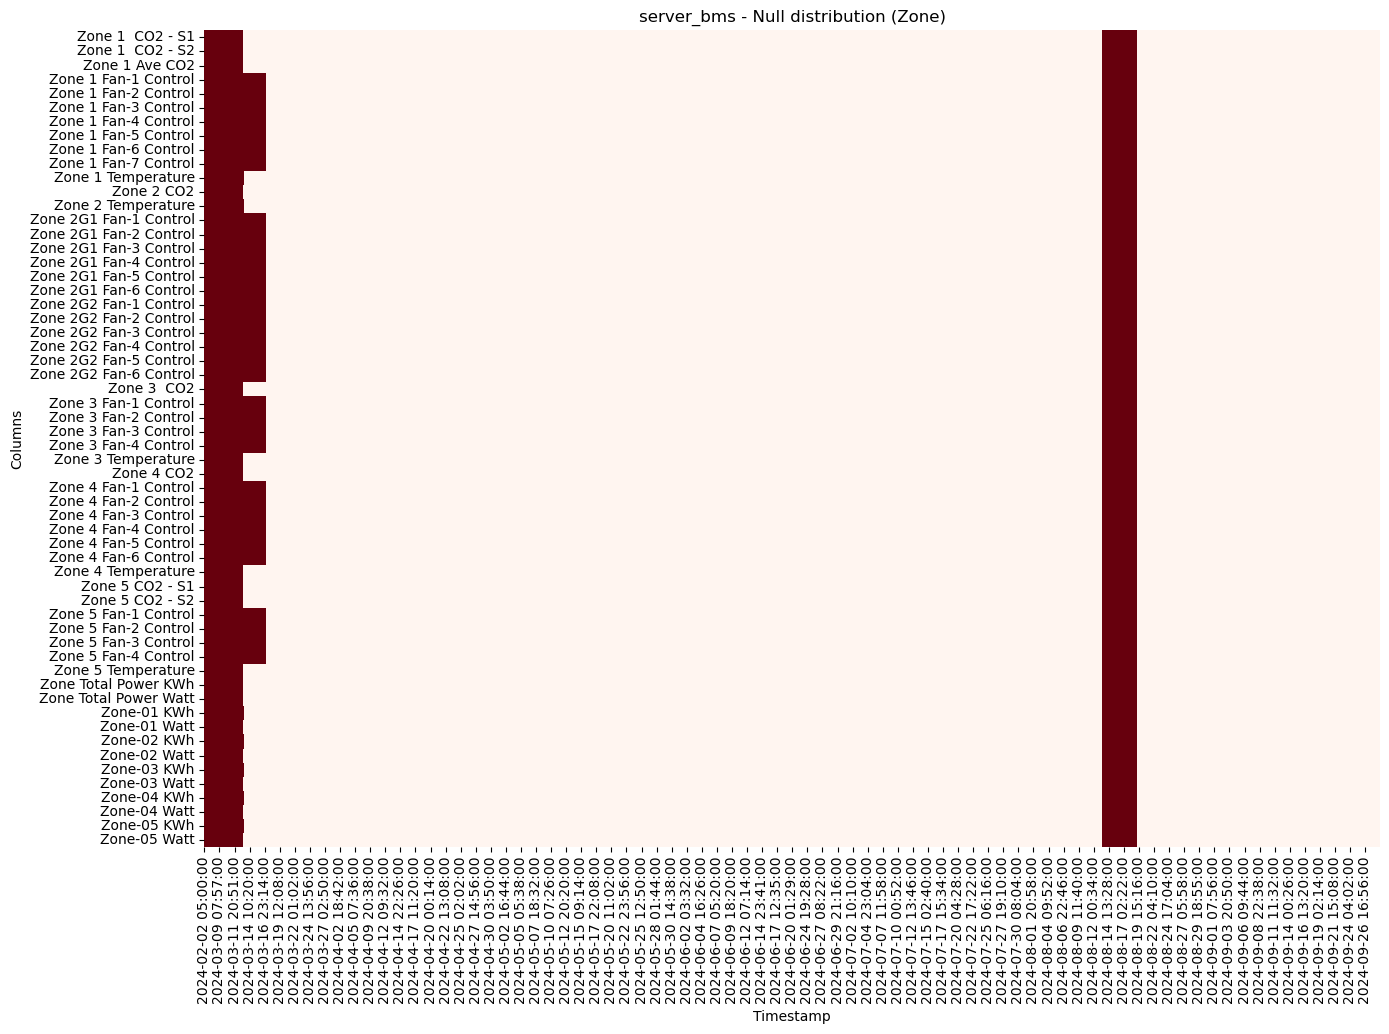

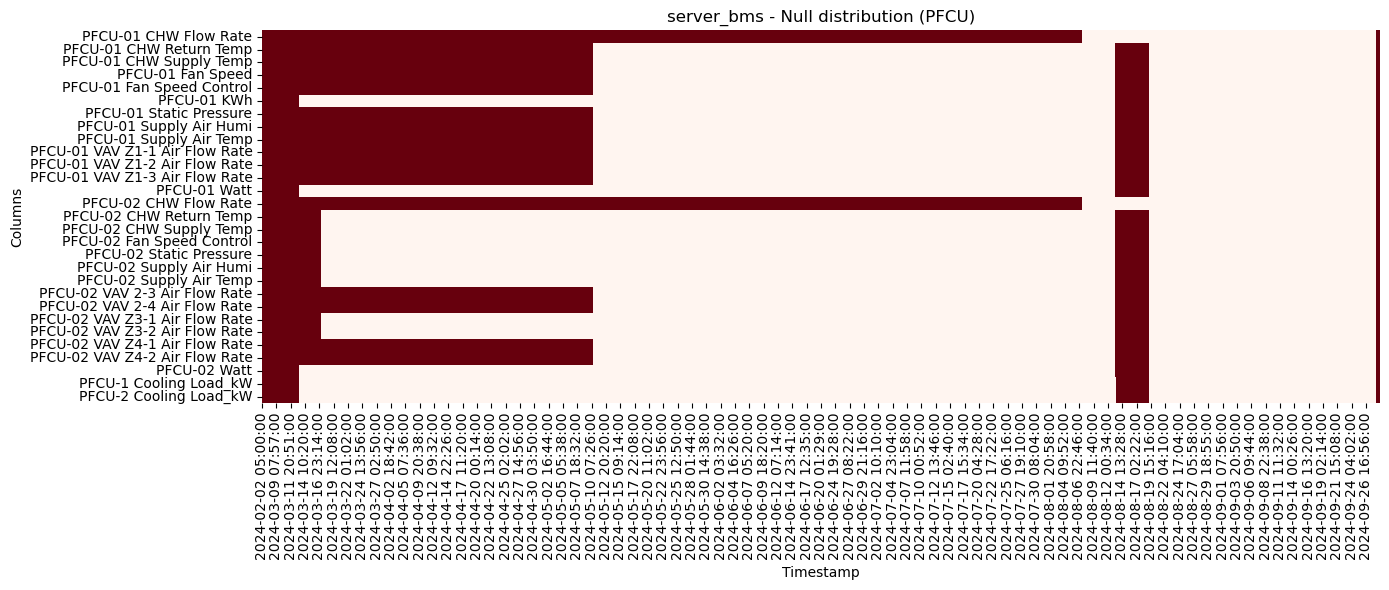

In [102]:
# dictionary instead of list
all_cols_groups = {
    "Outdoor": outdoor_cols,
    "Main": main_cols,
    "Window": window_cols,
    "FCU": fcu_cols,
    "Zone": zone_cols,
    "PFCU": pfcu_cols
}

for group_name, cols in all_cols_groups.items():
    null_mask = dfs['server_bms'][cols].isna()
    null_mask.index = dfs['server_bms']["Timestamp"]
    
    n_rows = len(null_mask.columns)  # y축 라벨 개수
    fig_height = max(6, n_rows * 0.18)  # 최소 6, 컬럼당 0.3씩 높이 증가

    plt.figure(figsize=(14, fig_height))
    sns.heatmap(null_mask.T, cmap="Reds", cbar=False, yticklabels=null_mask.columns)

    plt.title(f"server_bms - Null distribution ({group_name})")
    plt.xlabel("Timestamp")
    plt.ylabel("Columns")

    # plt.yticks(
    #     ticks=np.arange(n_rows)+0.5, 
    #     labels=null_mask.columns, 
    #     # fontsize=8  # 글자 크기도 필요에 따라 조정
    # )

    plt.tight_layout()
    plt.show()


# Summary

## (1) Describe

In [154]:
summary_all = test_df[outdoor_cols].describe(include='all')  
summary_all

,Outdoor Temperature,Outdoor Temp Ave,Outdoor Humidity,Wind Speed,Wind Direction,Solar Radiation
count,129659.000000,38384.000000,239873.000000,256041.000000,254423.000000,134126.000000
mean,295.120238,29.311955,771.417486,240.774409,1767.134734,320.386764
std,19.385254,1.973549,101.925561,192.849429,746.392061,295.309012
min,0.000000,22.895000,0.000000,0.000000,0.000000,0.000000
25%,281.000000,27.799999,705.000000,84.000000,1358.000000,72.000000
50%,295.000000,28.980000,788.000000,190.000000,1774.000000,237.000000
75%,310.000000,30.820000,842.000000,354.000000,2061.000000,492.000000
max,352.000000,34.820000,1000.000000,1398.000000,3599.000000,1459.000000


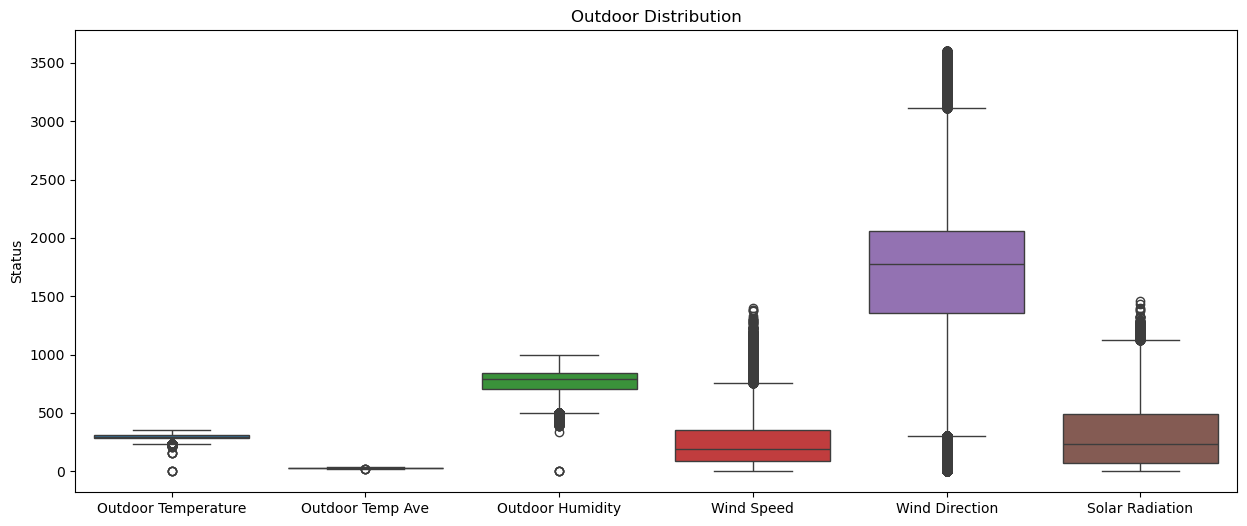

In [137]:
plt.figure(figsize=(15,6)) 
sns.boxplot(data=test_df[outdoor_cols])
plt.title("Outdoor Distribution")
plt.ylabel("Status")
plt.show()

In [121]:
summary_all = test_df[main_cols].describe(include='all')  
summary_all

,Main Incomming Watt,Main Incomming KWh
count,58834.000000,58833.000000
mean,457.300182,457.556396
std,216.828828,219.521096
min,296.837463,296.837463
25%,326.831421,326.829453
50%,332.797066,332.797104
75%,553.384331,553.030670
max,1985.695923,4621.371094


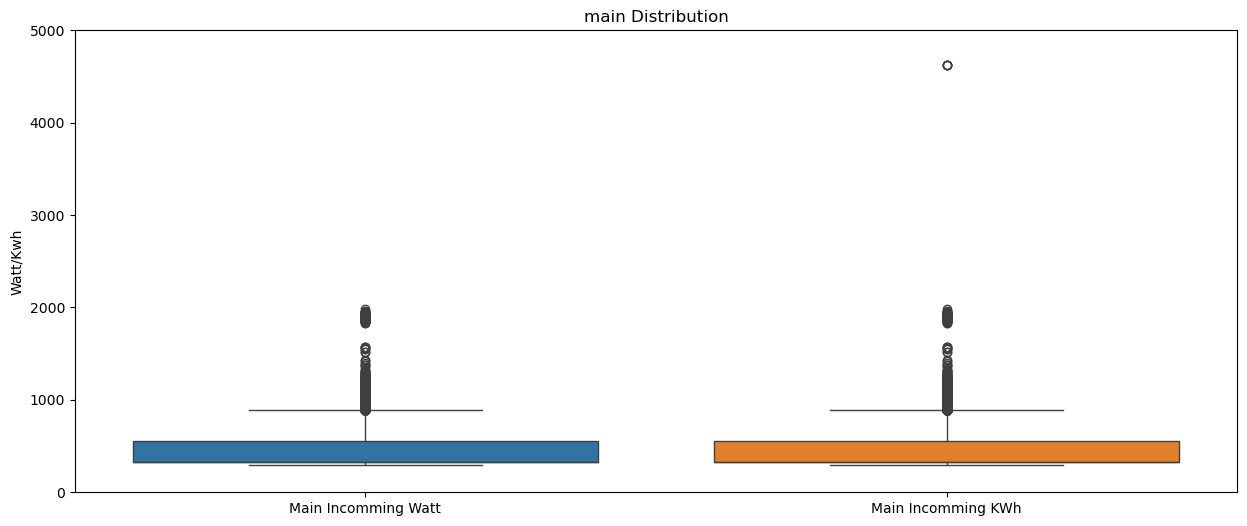

In [141]:
plt.figure(figsize=(15,6)) 
sns.boxplot(data=test_df[main_cols])
plt.title("main Distribution")
plt.ylabel("Watt/Kwh")
plt.ylim(0, 5000)
plt.show()

In [127]:
summary_all = test_df[window_cols].describe(include='all')  
summary_all

,Z1 Windows Open Close Status,Z1 Windows Open Close Status COV,Z2 Windows Open Close Status,Z2 Windows Open Close Status COV,Z3 Windows Open Close Status,Z3 Windows Open Close Status COV,Z5 Windows Open Close Status,Z5 Windows Open Close Status COV,Z6 Windows Open Close Status,Z6 Windows Open Close Status COV,Z7 Windows Open Close Status,Z7 Windows Open Close Status COV
count,116890.000000,349.000000,116881.000000,345.000000,116634.000000,372.000000,116863.000000,372.000000,116942.000000,359.000000,117120.000000,357.000000
mean,0.129866,0.604585,0.129790,0.605797,0.158959,0.618280,0.129879,0.607527,0.126918,0.604457,0.129081,0.605042
std,0.336157,0.489642,0.336074,0.489389,0.365639,0.486463,0.336171,0.488959,0.332882,0.489649,0.335291,0.489528
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [131]:
summary_all = test_df[fcu_cols[:12]].describe(include='all')  
summary_all

,FCU-01 CHW Flow Rate,FCU-01 CHW Return Temp,FCU-01 CHW Supply Temp,FCU-01 KWh,FCU-01 Return Air CO2 Level,FCU-01 Return Air Humi,FCU-01 Return Temp,FCU-01 Supply Air Flow Rate,FCU-01 Supply Air Humi,FCU-01 Supply Air Temp,FCU-01 Temp Set Point,FCU-01 Watt
count,74865.000000,190719.000000,190715.000000,265480.000000,190717.000000,190717.000000,190718.000000,190672.000000,190720.000000,190720.000000,42027.000000,265586.000000
mean,250.612876,23.680512,23.159867,225.517740,431.235037,71.855205,28.510181,0.775945,80.974254,26.529039,27.556797,37.441131
std,627.183153,4.939773,8.203593,46.843240,38.792328,5.494913,0.895883,1.575387,7.529565,4.807079,0.280301,68.086717
min,0.000000,0.000000,0.000000,109.504997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,9.094674
25%,0.000000,21.685631,16.805170,204.876007,408.255963,68.968056,27.941765,0.075000,75.988556,27.077604,27.500000,10.927411
50%,47.080917,24.579048,26.766537,228.932999,418.397053,72.733102,28.638942,0.110000,78.805298,28.567129,27.500000,11.130755
75%,135.191200,27.725199,29.912693,253.623993,437.730786,75.666400,29.157237,0.130000,83.389233,29.283698,27.500000,11.404692
max,3493.721069,30.154972,32.307632,296.167999,723.286759,87.991205,30.697266,13.754039,95.812012,30.993750,29.000000,537.927877


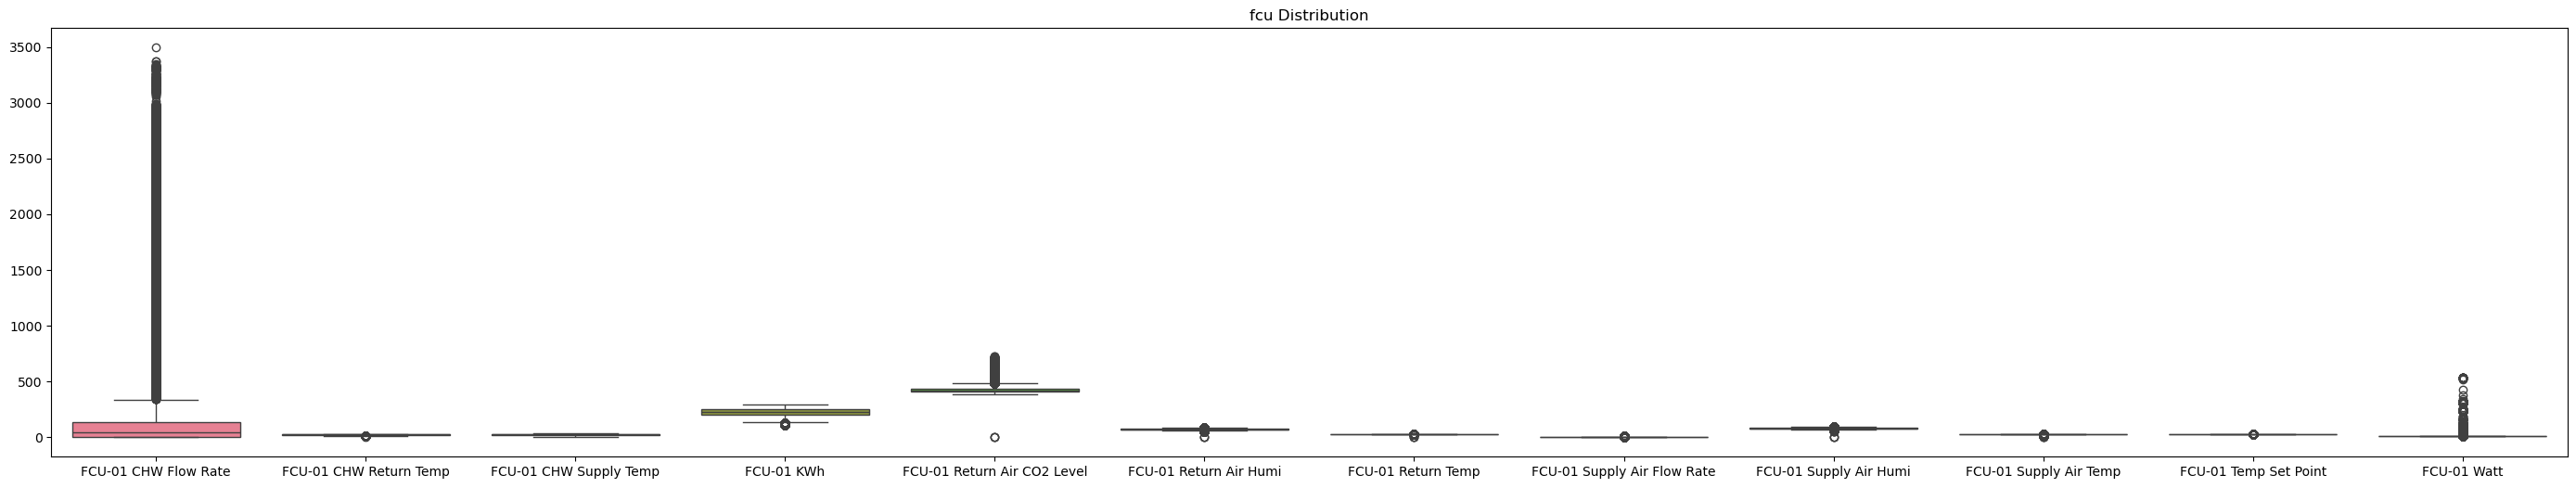

In [144]:
plt.figure(figsize=(35,6)) 
sns.boxplot(data=test_df[fcu_cols[:12]])
plt.title("fcu Distribution")
# plt.ylabel("Watt/Kwh")
# plt.ylim(0, 5000)
plt.show()

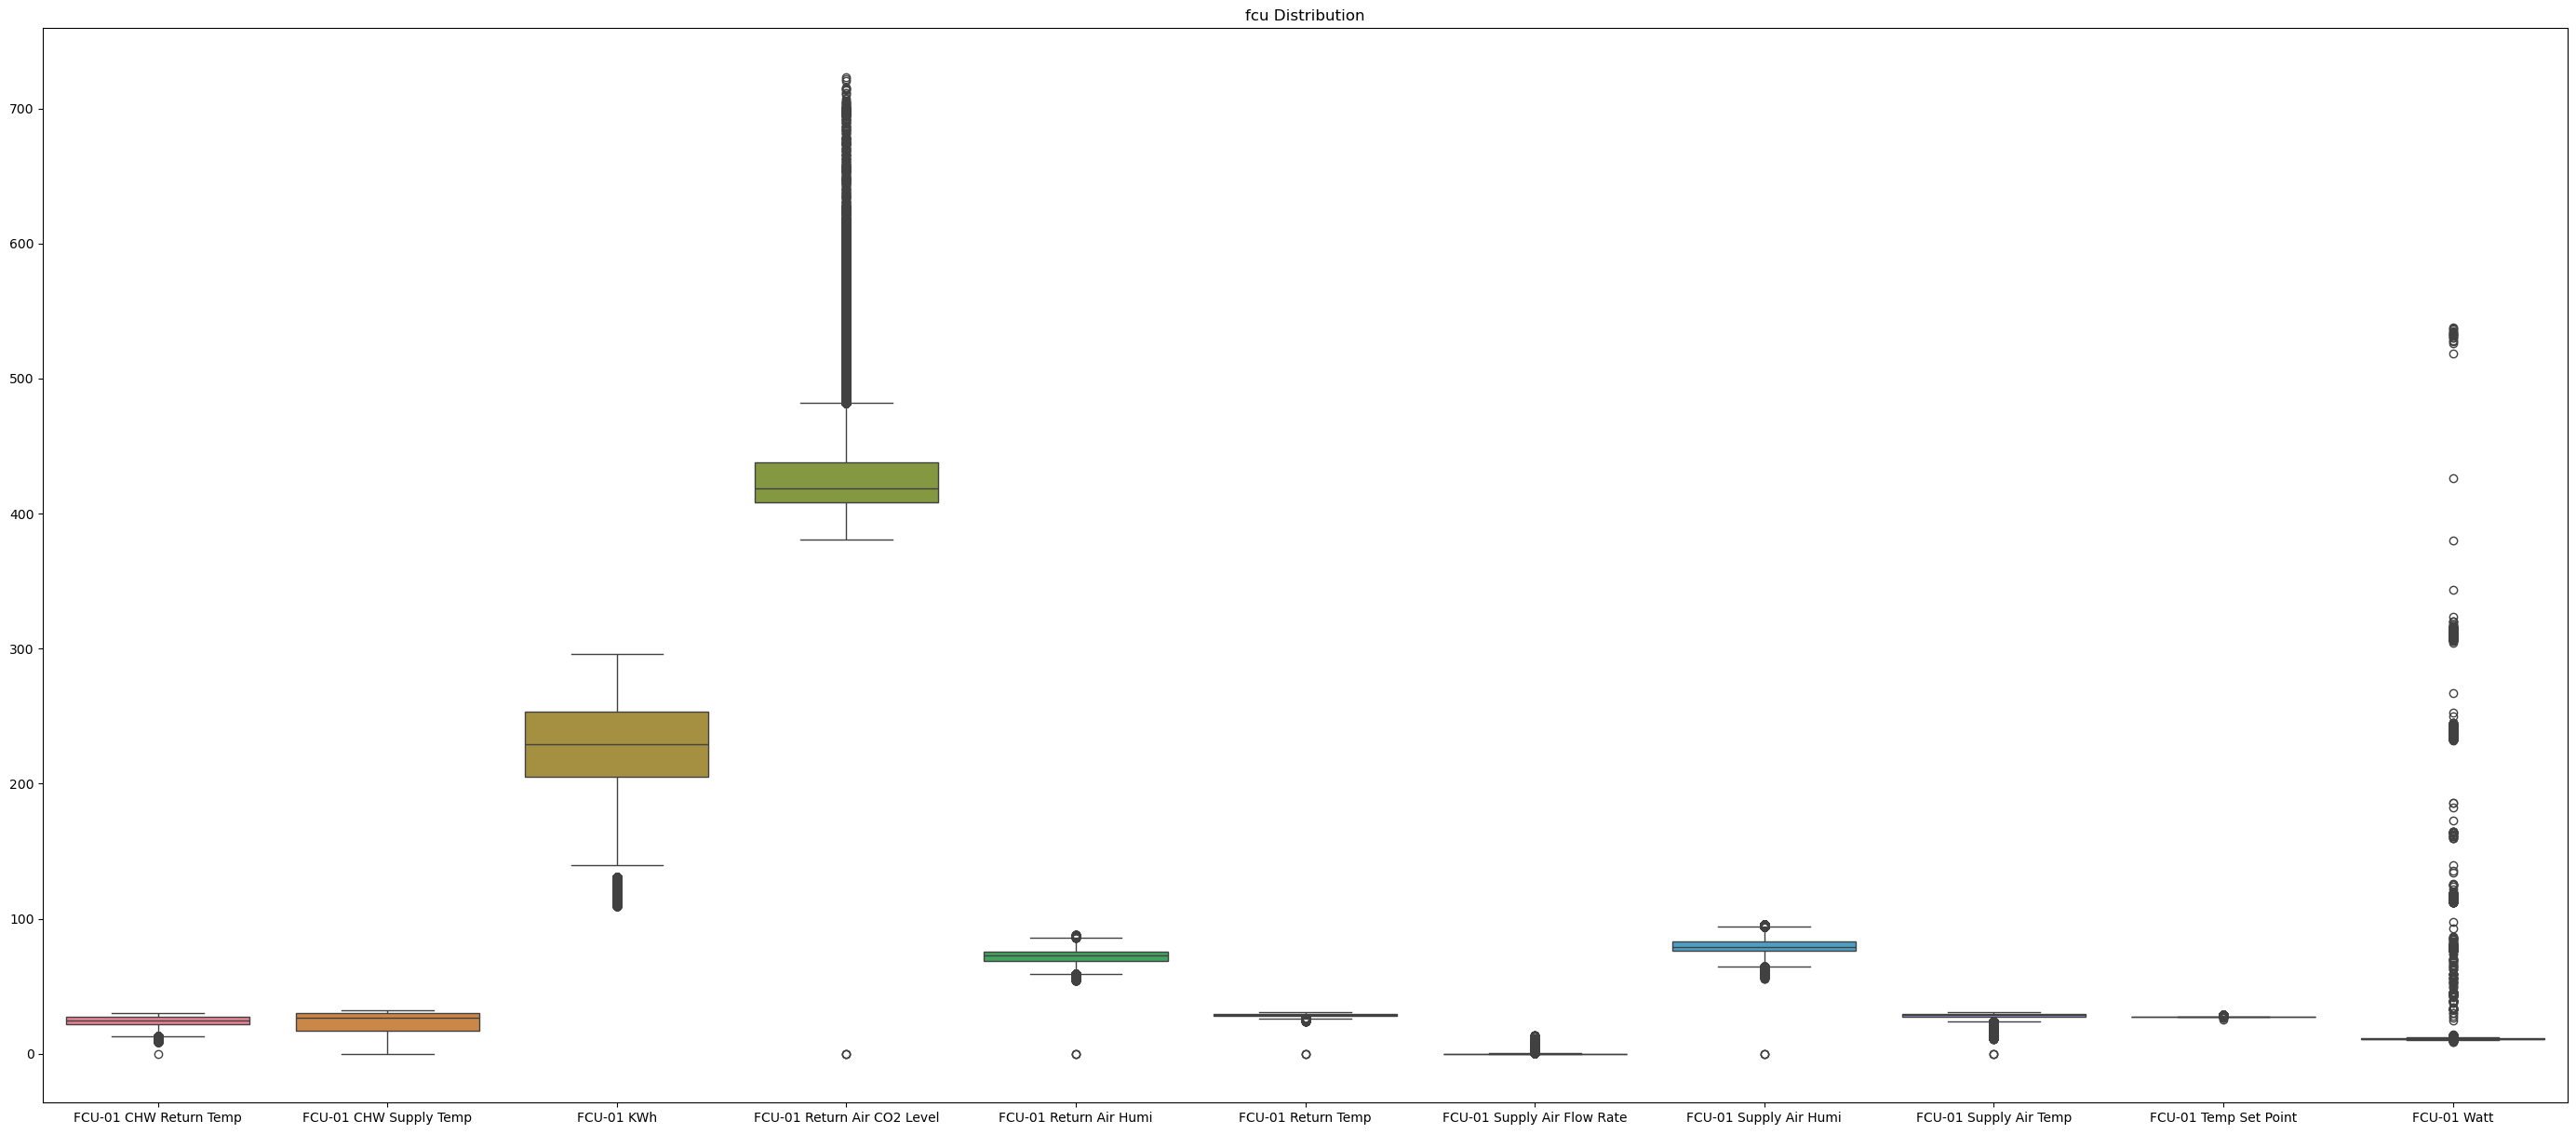

In [146]:
plt.figure(figsize=(35,15)) 
sns.boxplot(data=test_df[fcu_cols[1:12]])
plt.title("fcu Distribution")
# plt.ylabel("Watt/Kwh")
# plt.ylim(0, 1500)
plt.show()

In [133]:
summary_all = test_df[pfcu_cols[:13]].describe(include='all')  
summary_all

,PFCU-01 CHW Flow Rate,PFCU-01 CHW Return Temp,PFCU-01 CHW Supply Temp,PFCU-01 Fan Speed,PFCU-01 Fan Speed Control,PFCU-01 KWh,PFCU-01 Static Pressure,PFCU-01 Supply Air Humi,PFCU-01 Supply Air Temp,PFCU-01 VAV Z1-1 Air Flow Rate,PFCU-01 VAV Z1-2 Air Flow Rate,PFCU-01 VAV Z1-3 Air Flow Rate,PFCU-01 Watt
count,74886.000000,190894.000000,190895.000000,190813.000000,190812.000000,265688.000000,190887.000000,190892.000000,190889.000000,190870.000000,190893.000000,190900.000000,265753.000000
mean,522.491988,22.600487,19.979352,72.485173,72.345316,329.934495,15.311841,80.559906,26.567867,2.882338,124.649249,188.712564,86.333620
std,467.512272,5.306542,8.517391,15.043905,15.144484,115.853647,31.311520,8.802817,3.949343,24.723611,208.048624,309.025985,128.407625
min,0.000000,7.868457,7.677419,0.000000,0.000000,124.703003,1.093745,43.215501,11.781250,0.492512,-131.554380,0.492512,4.816532
25%,149.665131,17.650532,9.549600,75.000000,75.000000,236.815994,1.406260,73.256874,21.218750,0.661250,0.323755,0.998766,6.977465
50%,333.581940,23.629101,22.618145,75.000000,75.000000,325.226990,3.125016,77.650620,28.775002,0.829988,0.380007,1.336241,7.188185
75%,754.821650,27.620619,28.213247,75.000000,75.000000,420.710999,33.437517,90.903125,29.368750,0.829988,344.929988,533.304829,284.891037
max,4570.998535,30.436176,31.396145,100.000000,100.000000,532.914978,599.843750,95.498749,33.512501,1765.125000,2562.907568,1166.667542,534.692993


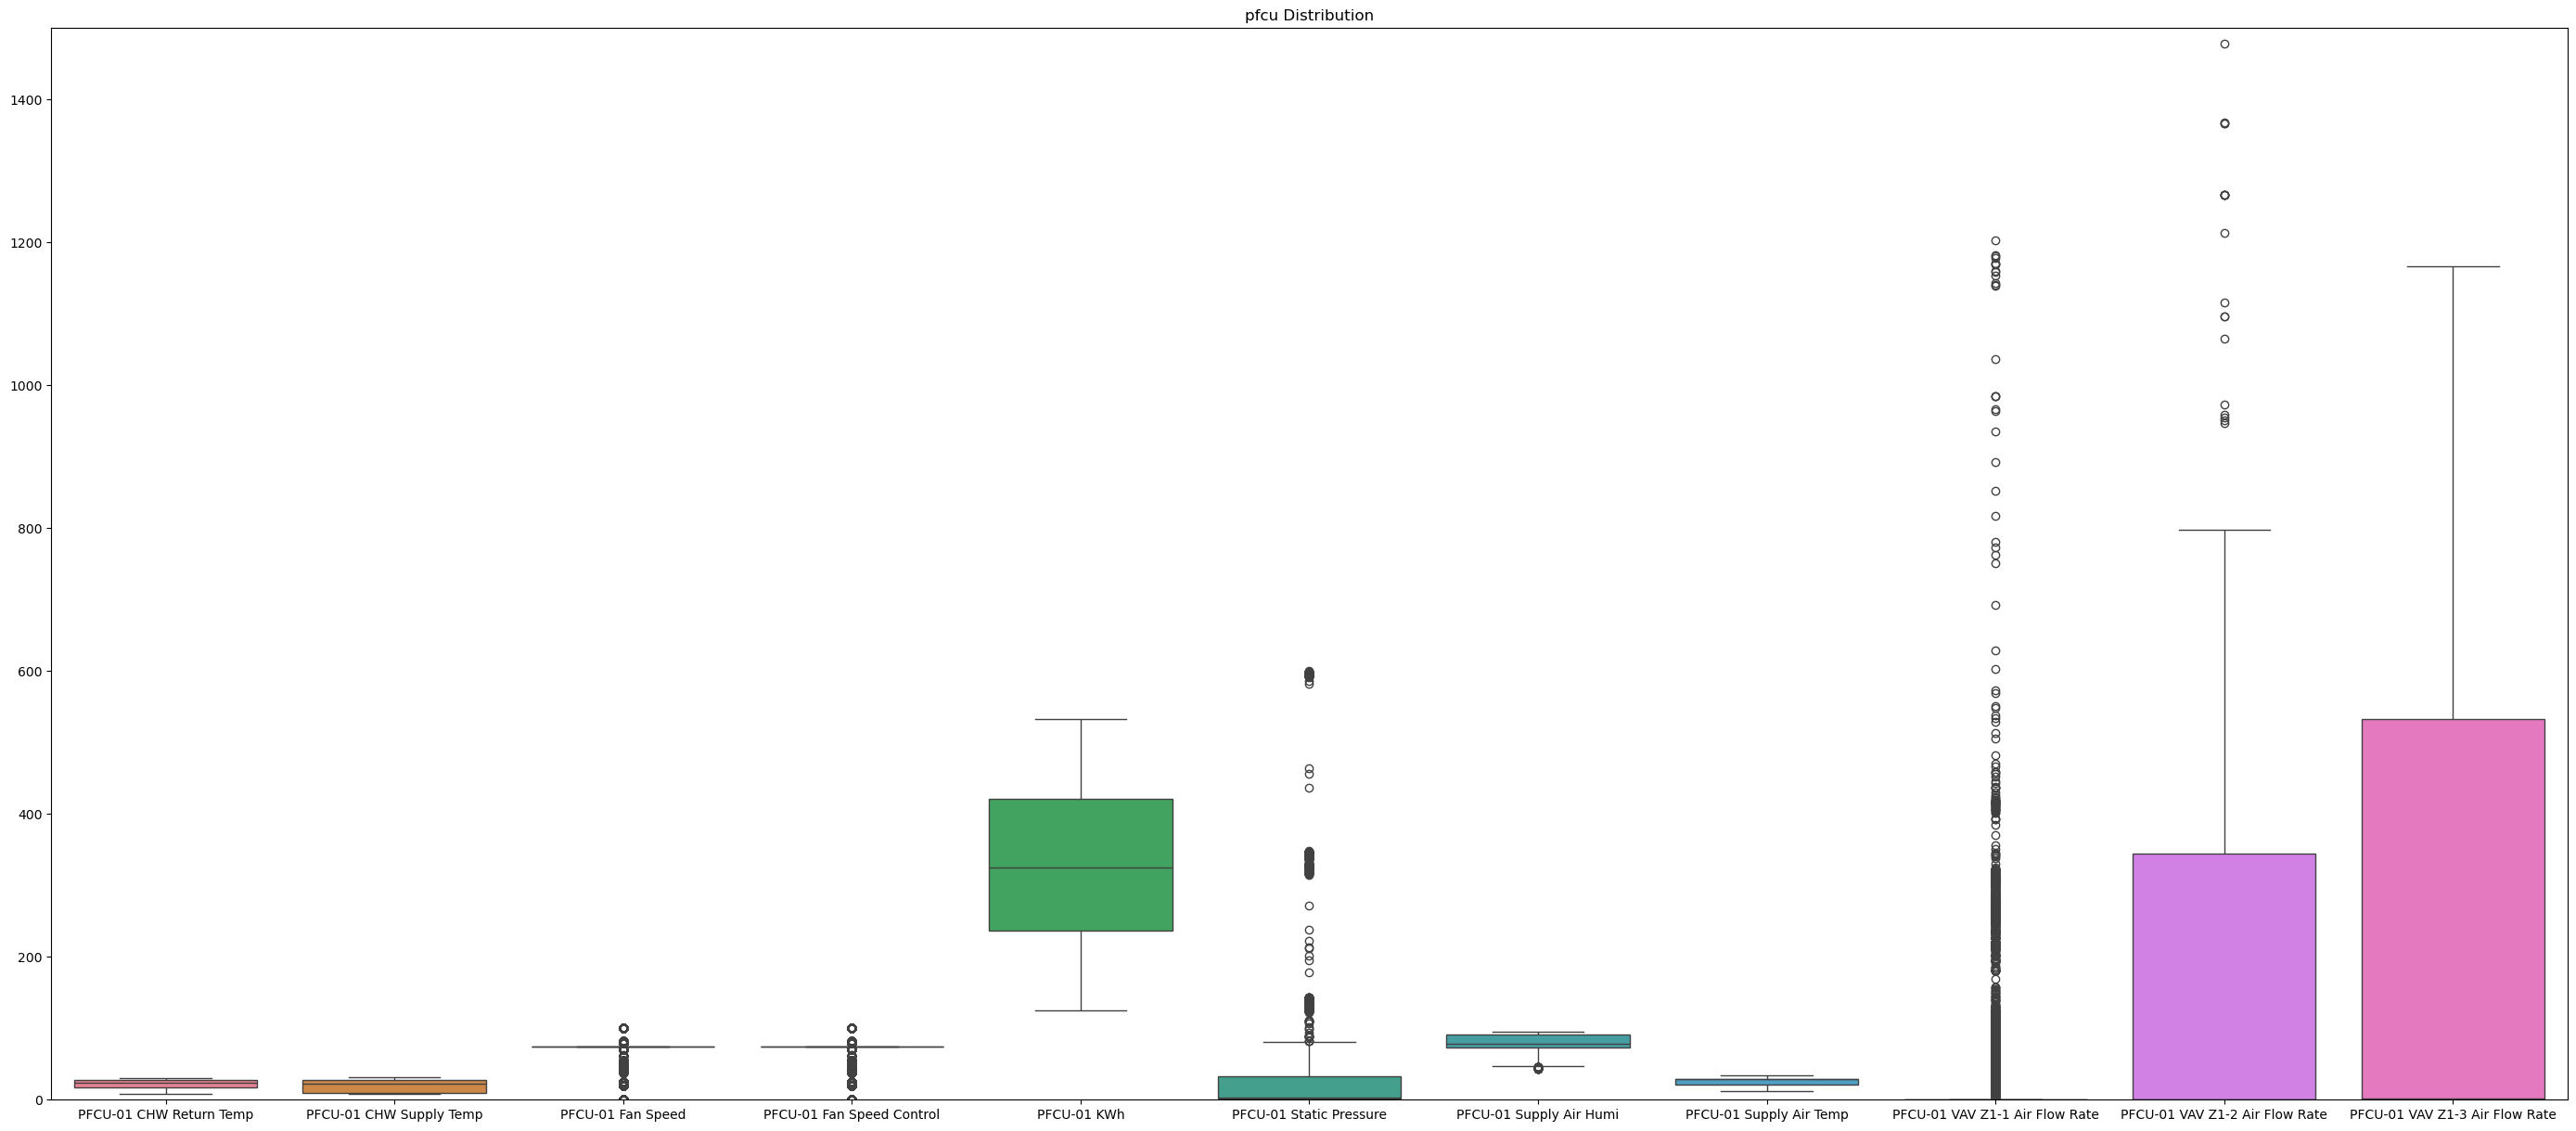

In [150]:
plt.figure(figsize=(35,15)) 
sns.boxplot(data=test_df[pfcu_cols[1:12]])
plt.title("pfcu Distribution")
# plt.ylabel("Watt/Kwh")
plt.ylim(0, 1500)
plt.show()

In [155]:
summary_all = test_df[zone_cols[:11]].describe(include='all')  
summary_all

,Zone 1 CO2 - S1,Zone 1 CO2 - S2,Zone 1 Ave CO2,Zone 1 Fan-1 Control,Zone 1 Fan-2 Control,Zone 1 Fan-3 Control,Zone 1 Fan-4 Control,Zone 1 Fan-5 Control,Zone 1 Fan-6 Control,Zone 1 Fan-7 Control,Zone 1 Temperature
count,266840.000000,266839.000000,266836.000000,261338.000000,261336.000000,261336.000000,261336.000000,261337.000000,261336.000000,261336.000000,266806.000000
mean,444.364148,446.246703,445.305507,15.458253,15.449423,15.439023,15.453596,15.440445,15.474936,15.346804,29.697582
std,37.820033,43.298403,39.209770,23.105841,23.088441,23.084003,23.112177,23.111891,23.117936,23.066406,1.155062
min,367.250000,382.333333,389.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.825001
25%,421.250000,420.250000,420.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.981251
50%,431.874977,430.499969,430.874969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.981249
75%,452.500015,452.833333,453.031250,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,30.618752
max,696.500000,738.000037,716.656250,90.000000,80.000000,80.000000,100.000000,80.000000,80.000000,80.000000,33.487501


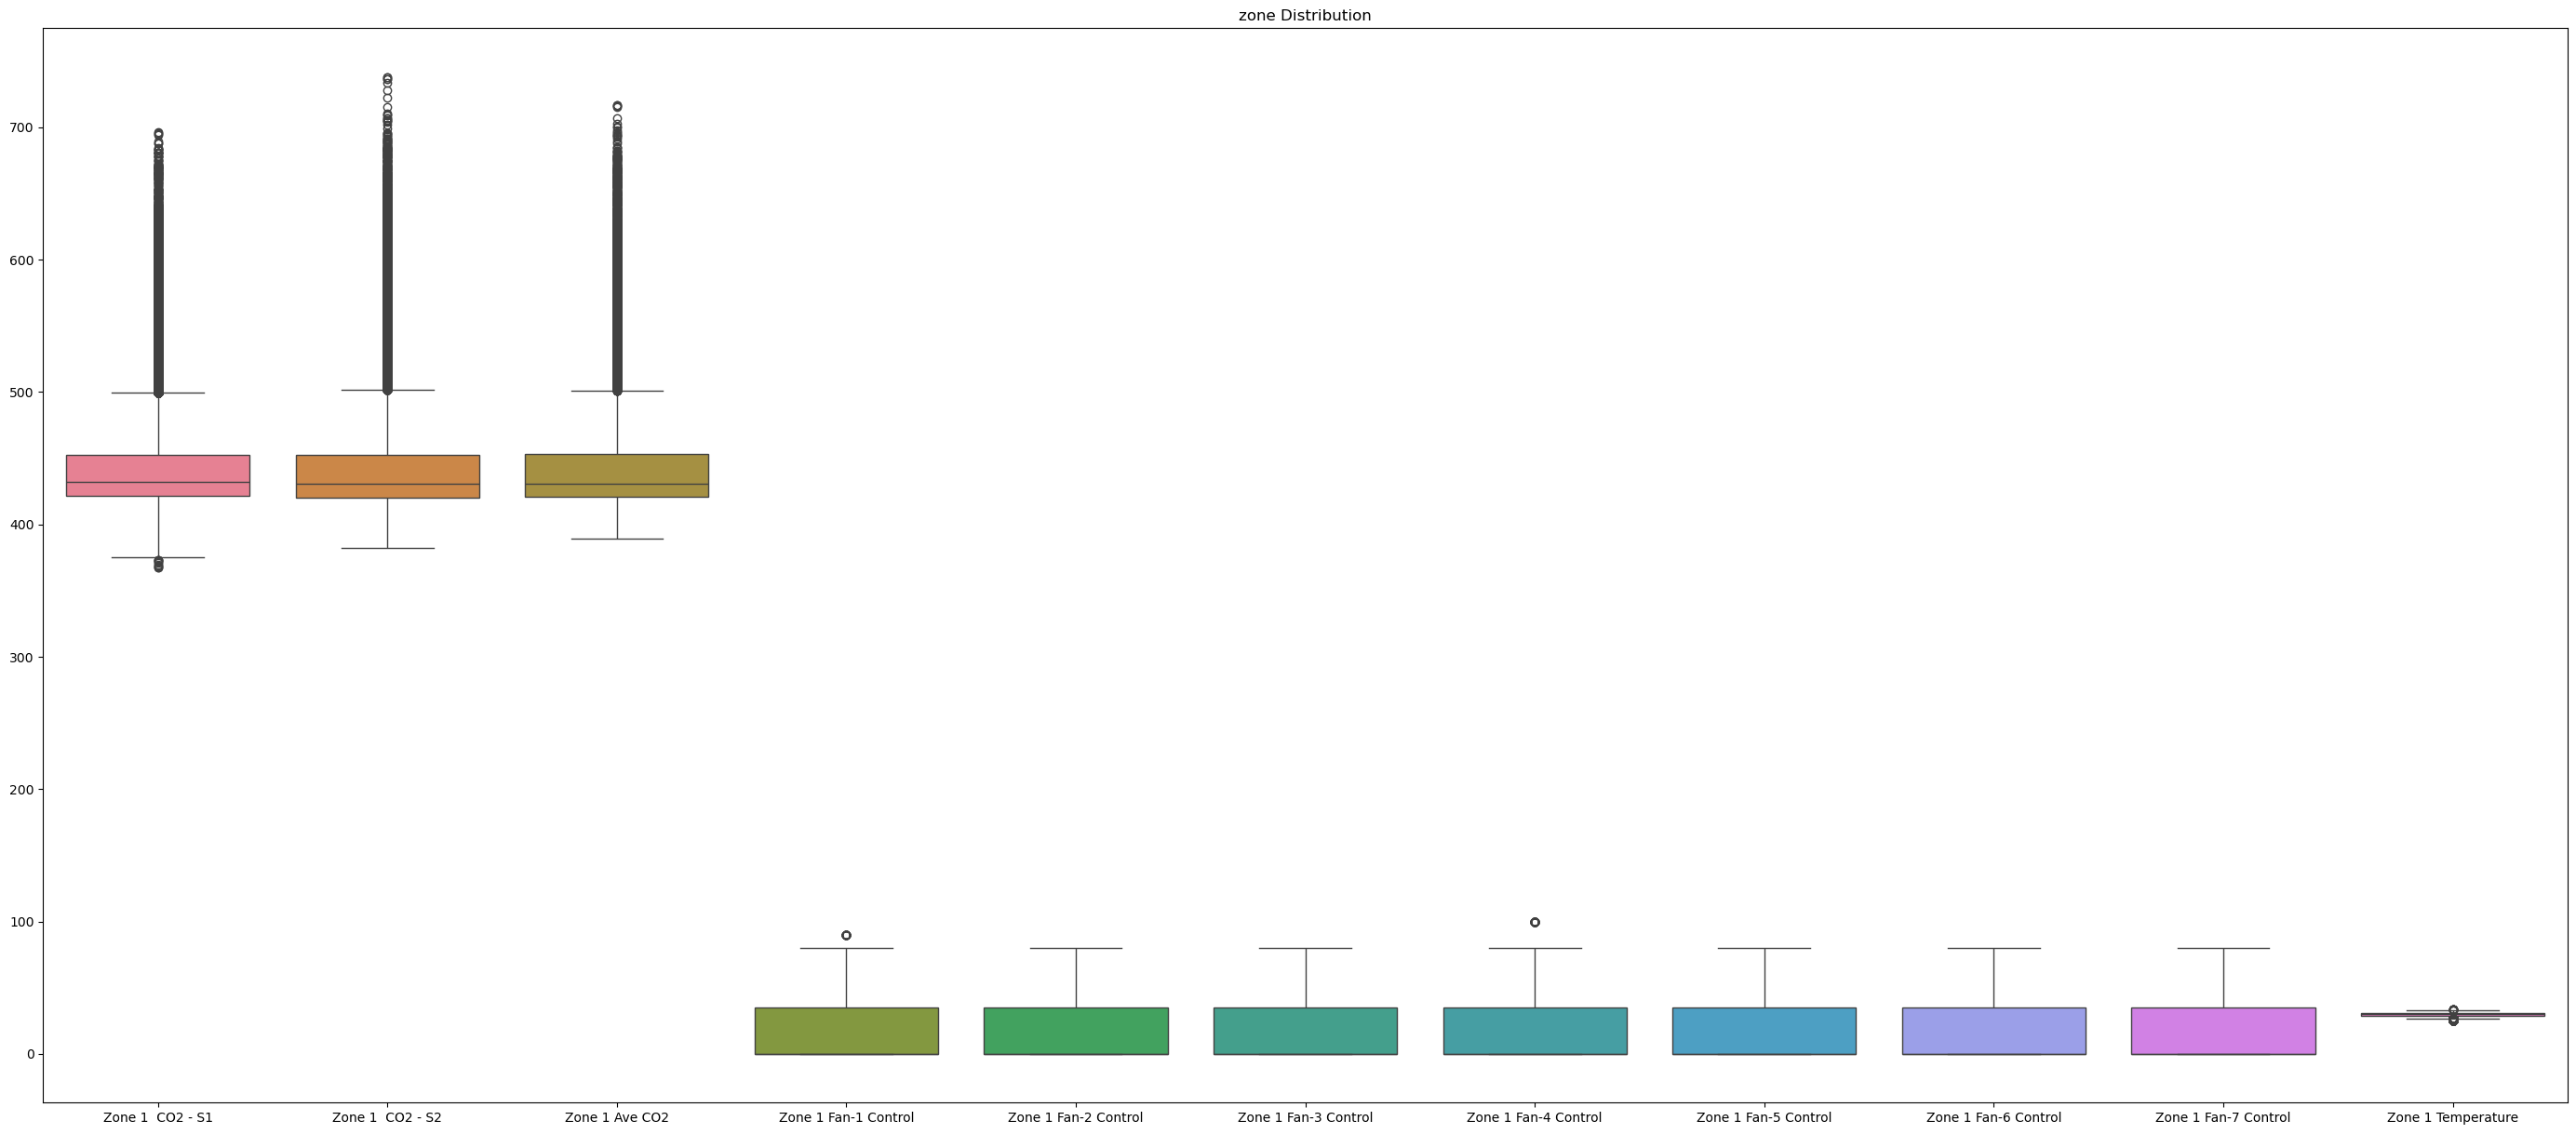

In [151]:
plt.figure(figsize=(35,15)) 
sns.boxplot(data=test_df[zone_cols[:11]])
plt.title("zone Distribution")
# plt.ylabel("Watt/Kwh")
# plt.ylim(0, 1500)
plt.show()

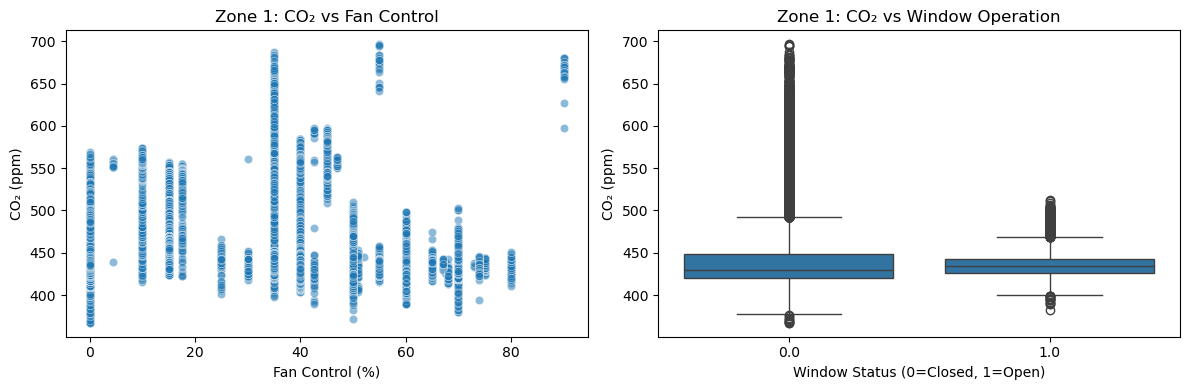

In [109]:
# 예시: Zone 1
df_z1 = test_df[['Zone 1  CO2 - S1', 'Zone 1 Fan-1 Control', 'Z1 Windows Open Close Status']].dropna()

plt.figure(figsize=(12,4))

# CO2 vs Fan
plt.subplot(1,2,1)
sns.scatterplot(x='Zone 1 Fan-1 Control', y='Zone 1  CO2 - S1', data=df_z1, alpha=0.5)
plt.title("Zone 1: CO₂ vs Fan Control")
plt.xlabel("Fan Control (%)")
plt.ylabel("CO₂ (ppm)")

# CO2 vs Window
plt.subplot(1,2,2)
sns.boxplot(x='Z1 Windows Open Close Status', y='Zone 1  CO2 - S1', data=df_z1)
plt.title("Zone 1: CO₂ vs Window Operation")
plt.xlabel("Window Status (0=Closed, 1=Open)")
plt.ylabel("CO₂ (ppm)")

plt.tight_layout()
plt.show()


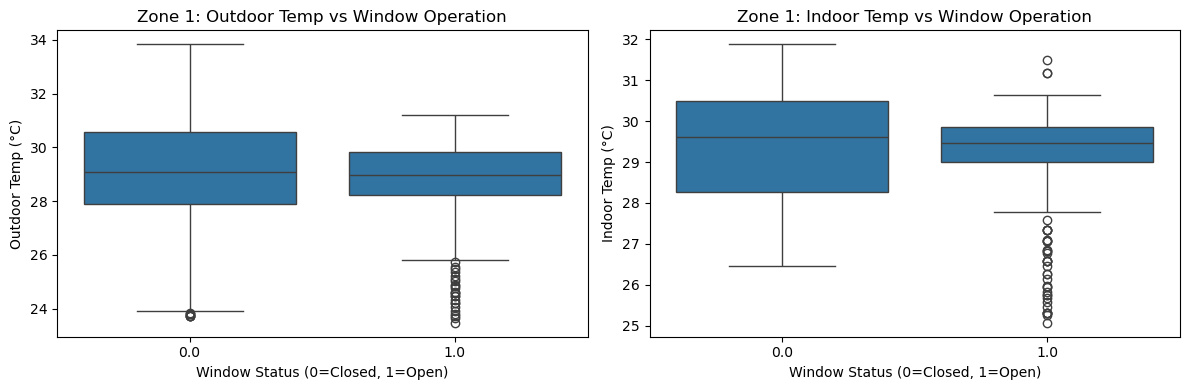

In [157]:
# 예시: Zone 1
df_z1_temp = test_df[['Outdoor Temp Ave', 'Zone 1 Temperature', 'Z1 Windows Open Close Status']].dropna()

plt.figure(figsize=(12,4))

# Outdoor Temp vs Window
plt.subplot(1,2,1)
sns.boxplot(x='Z1 Windows Open Close Status', y='Outdoor Temp Ave', data=df_z1_temp)
plt.title("Zone 1: Outdoor Temp vs Window Operation")
plt.xlabel("Window Status (0=Closed, 1=Open)")
plt.ylabel("Outdoor Temp (°C)")

# Indoor Temp vs Window
plt.subplot(1,2,2)
sns.boxplot(x='Z1 Windows Open Close Status', y='Zone 1 Temperature', data=df_z1_temp)
plt.title("Zone 1: Indoor Temp vs Window Operation")
plt.xlabel("Window Status (0=Closed, 1=Open)")
plt.ylabel("Indoor Temp (°C)")

plt.tight_layout()
plt.show()
